# D-Wave Analysis
This notebook demonstrates how to analyze spin configurations sampled from D-Wave to extract energy per spin, magnetization, number of domains, correlation length, and domain sizes, which is used to the distribution $P_A$ vs $A$.

# 1D

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from collections import Counter
import dimod
import pickle
import lzma
import pandas as pd
import gzip
import os
import time

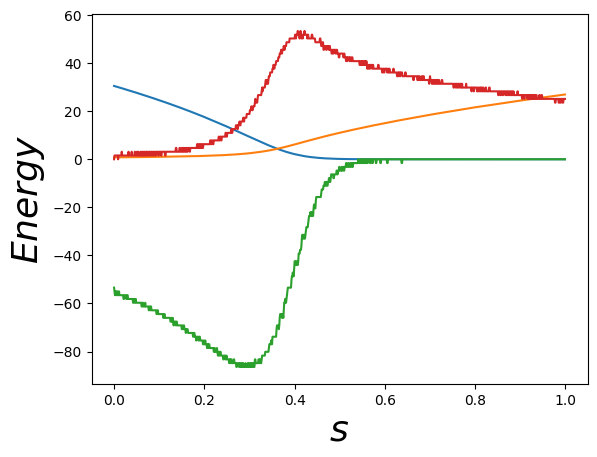

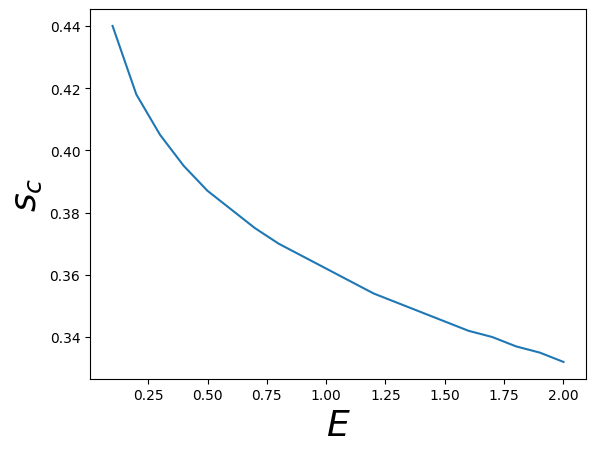

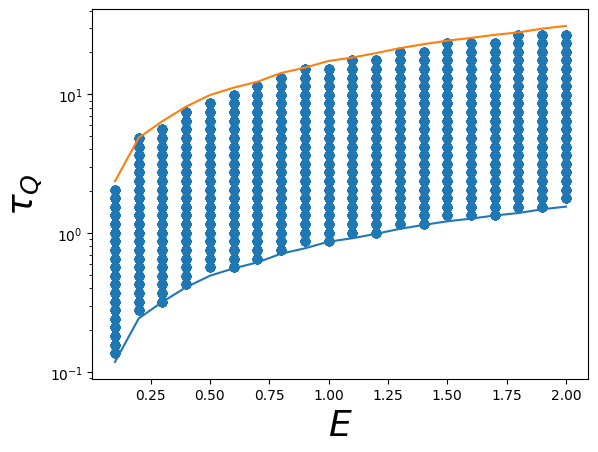

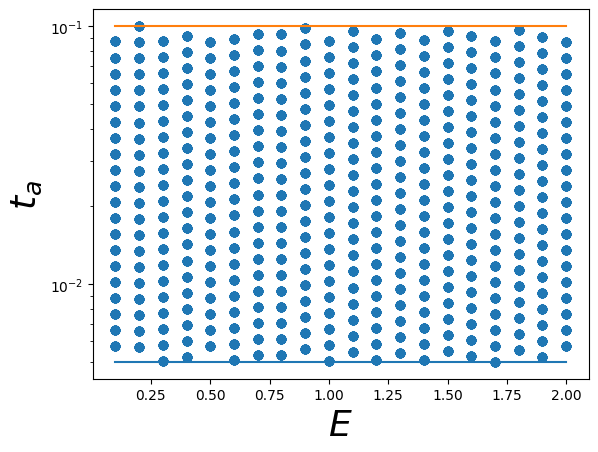

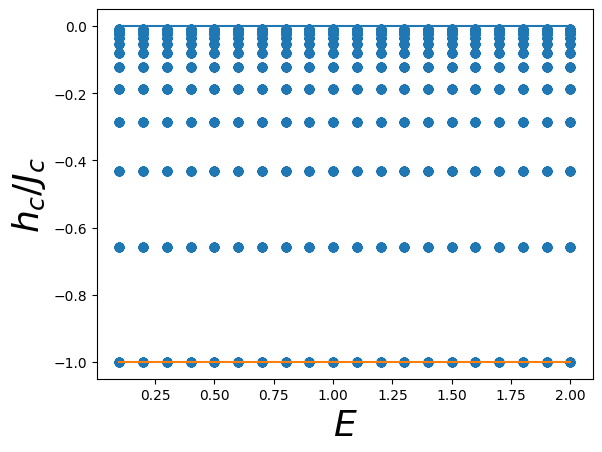

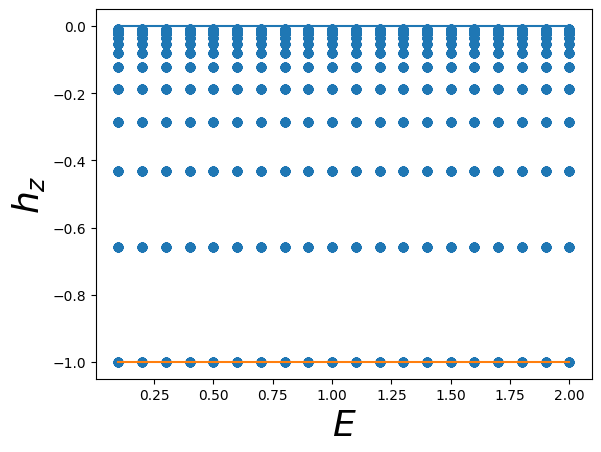

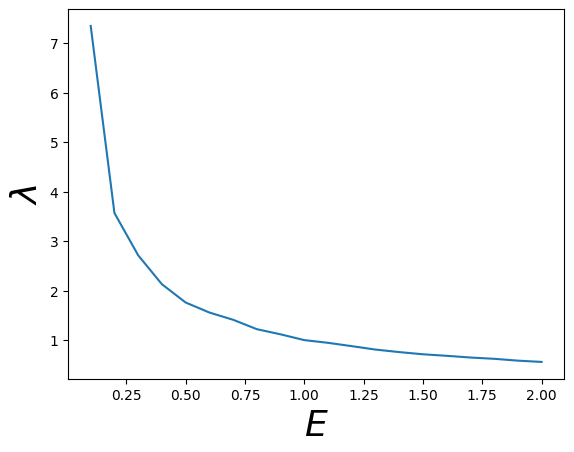

In [20]:
df = pd.read_csv('09-1265A-E_Advantage_system5_4_annealing_schedule.csv', sep=',', decimal='.')
sa = np.array([round(df['s'][i],3) for i in range(1000)])
Ga = np.array([round(df['A(s) (GHz)'][i],3)*np.pi for i in range(1000)])
Ja = np.array([round(df['B(s) (GHz)'][i],3)*np.pi for i in range(1000)])

L = 5564
J = -1.
num_reads = 1000

def sc(E,gc=1.):
    return sa[np.argmin(abs(Ga-gc*E*Ja))]
def Jc(E,gc=1.):
    return E * Ja[np.argmin(abs(Ga-gc*E*Ja))]
def Gc(E,gc=1.):
    return Ga[np.argmin(abs(Ga-gc*E*Ja))]
def Jcp(E,gc=1.):
    return np.gradient(E*Ja,sa)[np.argmin(abs(Ga-gc*E*Ja))]
def Gcp(E,gc=1.):
    return np.gradient(Ga,sa)[np.argmin(abs(Ga-gc*E*Ja))]
def tQ(ta,E,gc=1.):
    # ta must be in ns
    return ta / gc * Jc(E,gc) / (Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc))
def tQ_to_ta(tq,E,gc=1.):
    # ta must be in ns
    return tq * gc / Jc(E,gc) * (Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc))
def hcoJc(h,E,gc=1.):
    return h
def hcoJc_to_hz(hcoJc,E,gc=1.):
    return hcoJc
def en_to_lambda(E,gc=1.):
    return ((Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc)) / Jc(E,gc)) / ((Jcp(1.,gc)/Jc(1.,gc) - Gcp(1.,gc)/Gc(1.,gc)) / Jc(1.,gc))

en_range = np.linspace(.1,2.,20).round(6)

fig, ax = plt.subplots()
plt.xlabel('$s$', fontsize = 26)
plt.ylabel('$Energy$', fontsize = 26)
ax.plot(sa, Ga)
ax.plot(sa, Ja)
ax.plot(sa, np.gradient(Ga,sa))
ax.plot(sa, np.gradient(Ja,sa))

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$s_c$', fontsize = 26)
ax.plot(en_range, [sc(e) for e in en_range])
            
ens, ens1, tqs, tas, hcojs, hzs = [], [], [], [], [], []
for en in en_range:
    for tq in np.geomspace(tQ(5,.1),tQ(100,2.),40):
        if tQ(5,en) < tq < tQ(100,en):
            for hz in np.geomspace(hcoJc(-1.,.1,gc=1.), hcoJc(-.01,.1,gc=1.), 12):
                if hcoJc(-1.,en) <= hz <= hcoJc(-0.,en):
                    hcojs.append(hz.round(6))
                    hzs.append(hcoJc_to_hz(hz,en).round(6))
                    ens.append(en.round(6))
                    tqs.append(tq.round(6))
                    tas.append((tQ_to_ta(tq,en)/1000.).round(6))

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel(r'$\tau_Q$', fontsize = 26)
ax.plot(en_range, [tQ(5,e) for e in en_range])
ax.plot(en_range, [tQ(100,e) for e in en_range])
ax.scatter(ens,tqs)
#ax.legend(['$t_Q(t_a=5 ns, E)$','$t_Q(t_a=100 ns, E)$'])
ax.set_yscale('log')

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$t_a$', fontsize = 26)
ax.plot(en_range, [tQ_to_ta(tQ(5,e)/1000,e) for e in en_range])
ax.plot(en_range, [tQ_to_ta(tQ(100,e)/1000,e) for e in en_range])
ax.scatter(ens,tas)
#ax.legend(['$t_Q(t_a=5 ns, E)$','$t_Q(t_a=100 ns, E)$'])
ax.set_yscale('log')

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$h_c/J_c$', fontsize = 26)
ax.plot(en_range, [hcoJc(-0.,e) for e in en_range])
ax.plot(en_range, [hcoJc(-1.,e) for e in en_range])
ax.scatter(ens,hcojs)

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$h_z$', fontsize = 26)
ax.plot(en_range, [-0. for e in en_range])
ax.plot(en_range, [-1. for e in en_range])
ax.scatter(ens,hzs)

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel(r'$\lambda$', fontsize = 26)
ax.plot(en_range, [en_to_lambda(e) for e in en_range])

hzenta_range = [[ens[i],tas[i],hzs[i]] for i in range(len(ens))]

In [21]:
#Import results from D-Wave - Needed for the code below to work!

analysis_results_dir = 'D_Wave_data_dicts/'

with gzip.open(analysis_results_dir + '1D_tfim_1st_sweep_mag_1.txt.gz', "r") as f:
    fvd_mags = eval(f.read())

In [22]:
# PLOTTING CONVERSION

tqsu = np.unique(tqs)
hcojcsu = np.unique(hcojs)
datamag = {}
datanex = {}
keys = []
for tq in tqsu:
    for hcojc in hcojcsu:
        datamag[(tq,hcojc)] = []
        datanex[(tq,hcojc)] = []
        keys.append((tq,hcojc))

start = time.time()
for hzentaind, [en,ta,hz] in enumerate(hzenta_range):
    if (hzentaind < 1000 and hzentaind%100 == 1) or (hzentaind%1000 == 1):
        print(f'Converting i={hzentaind} / {len(hzenta_range)} (elapsed time so far: {time.time()-start:.2f} s, {(time.time()-start)/hzentaind:.2f} s per data set)')
    try:
        tq = tqsu[np.abs(tQ(1000*ta,en).round(6) - tqsu).argmin()]
        hcojc = hcojcsu[np.abs(hcoJc(hz,en) - hcojcsu).argmin()]
        datamag[(tq,hcojc)].append([en_to_lambda(en),fvd_mags[(L,J,hz,ta,en,num_reads,'szmean')]])
        datanex[(tq,hcojc)].append([en_to_lambda(en),fvd_mags[(L,J,hz,ta,en,num_reads,'nexmean')]])
    except:
        continue

for key in keys:
    if datamag[key] == []:
        del datamag[key]
        del datanex[key]
        print(key)

Converting i=1 / 5004 (elapsed time so far: 0.00 s, 0.00 s per data set)
Converting i=101 / 5004 (elapsed time so far: 0.16 s, 0.00 s per data set)
Converting i=201 / 5004 (elapsed time so far: 0.30 s, 0.00 s per data set)
Converting i=301 / 5004 (elapsed time so far: 0.45 s, 0.00 s per data set)
Converting i=401 / 5004 (elapsed time so far: 0.59 s, 0.00 s per data set)
Converting i=501 / 5004 (elapsed time so far: 0.75 s, 0.00 s per data set)
Converting i=601 / 5004 (elapsed time so far: 0.88 s, 0.00 s per data set)
Converting i=701 / 5004 (elapsed time so far: 1.04 s, 0.00 s per data set)
Converting i=801 / 5004 (elapsed time so far: 1.19 s, 0.00 s per data set)
Converting i=901 / 5004 (elapsed time so far: 1.35 s, 0.00 s per data set)
Converting i=1001 / 5004 (elapsed time so far: 1.50 s, 0.00 s per data set)
Converting i=2001 / 5004 (elapsed time so far: 2.96 s, 0.00 s per data set)
Converting i=3001 / 5004 (elapsed time so far: 4.46 s, 0.00 s per data set)
Converting i=4001 / 5004

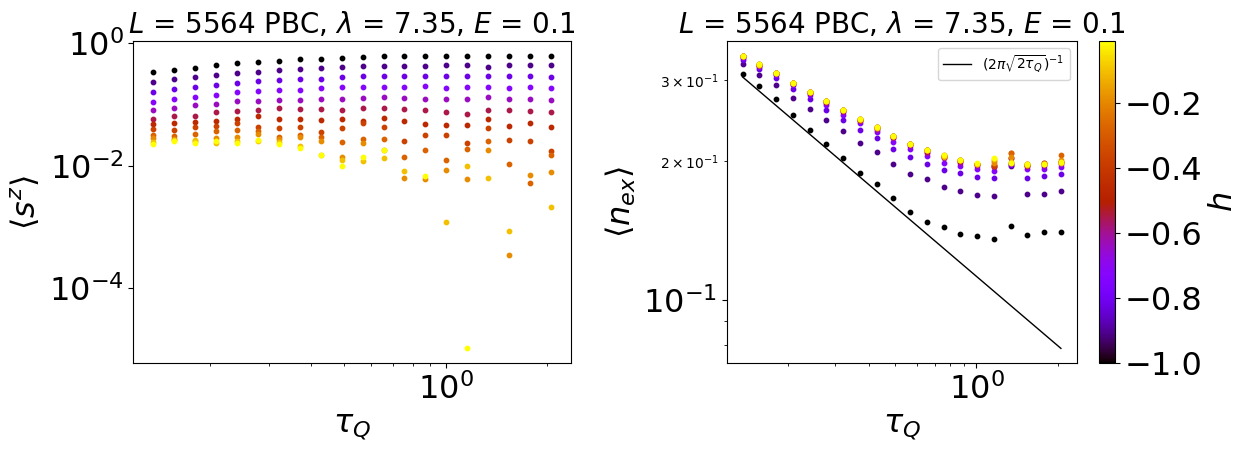

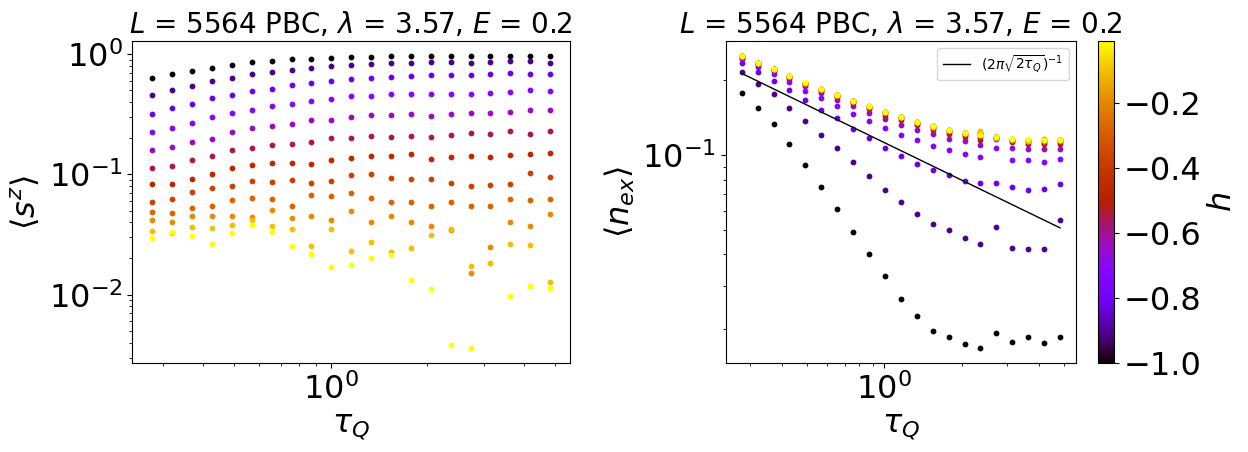

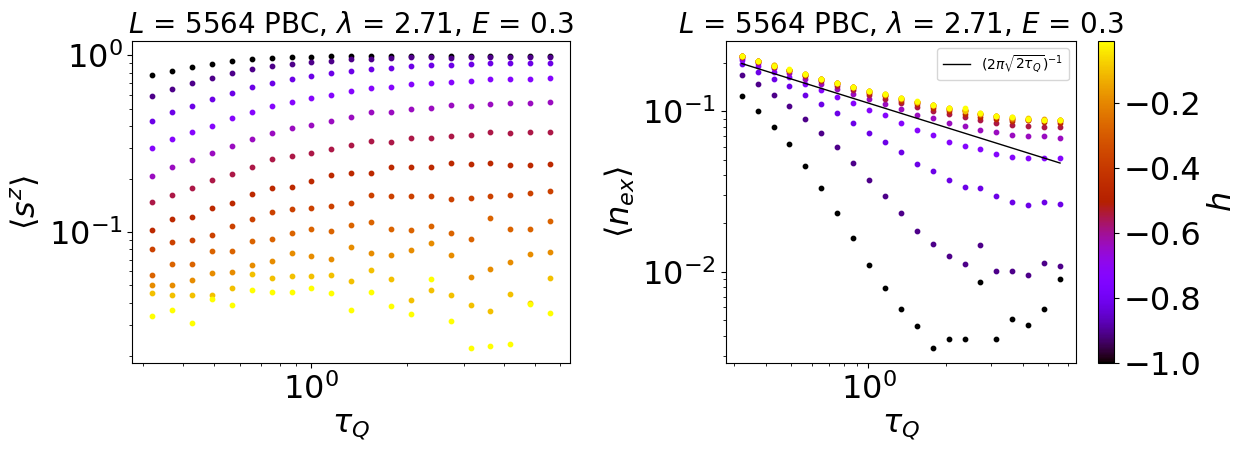

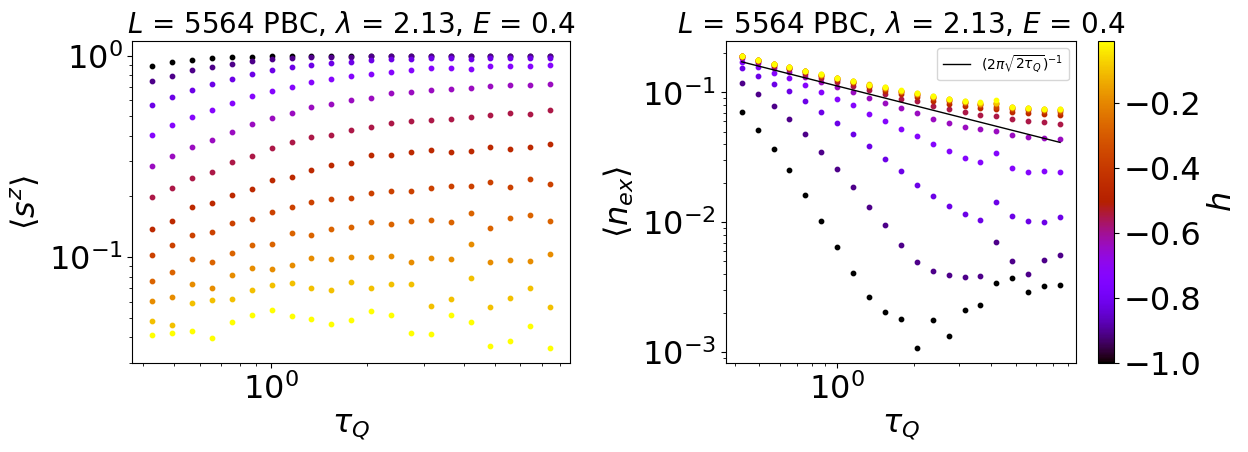

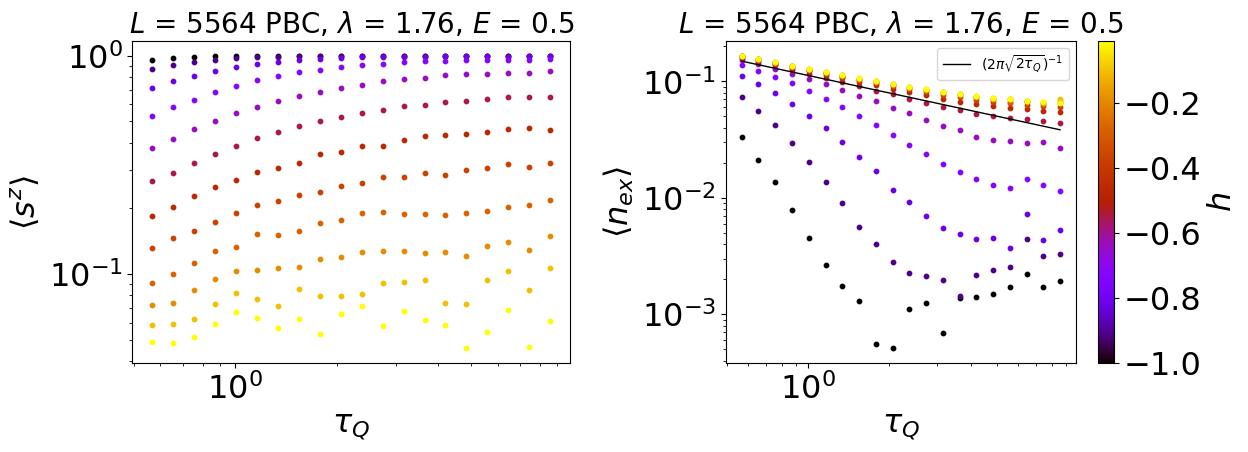

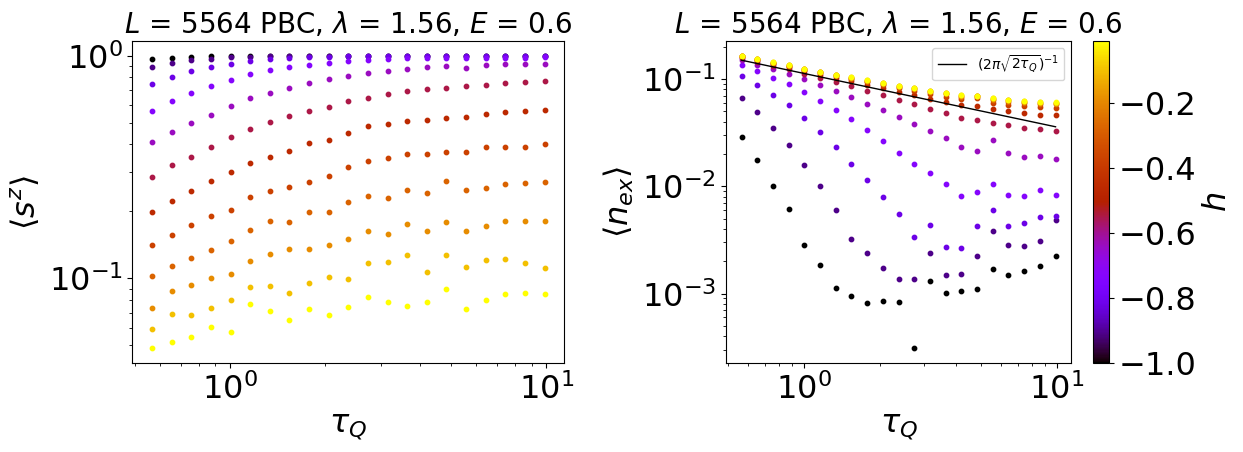

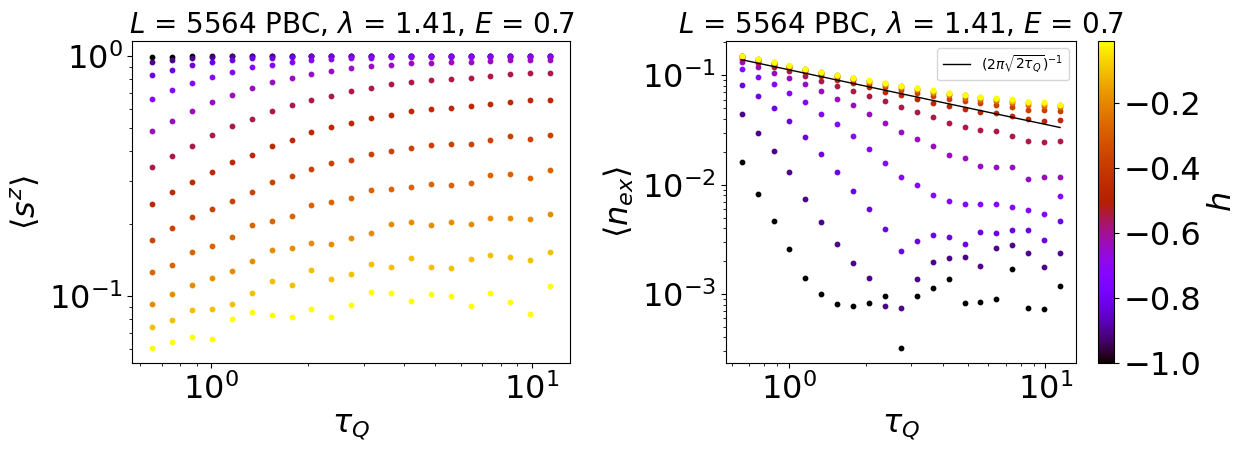

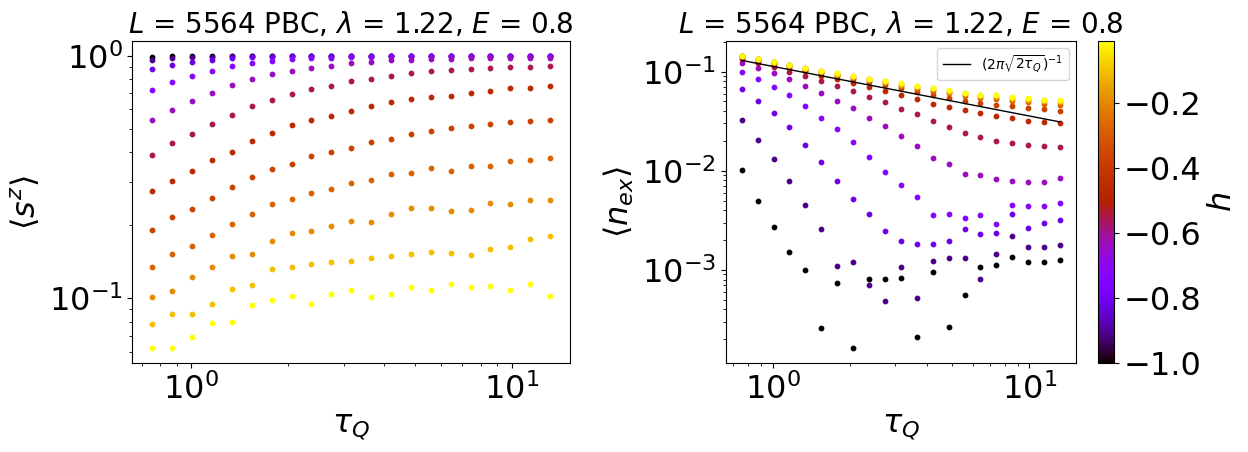

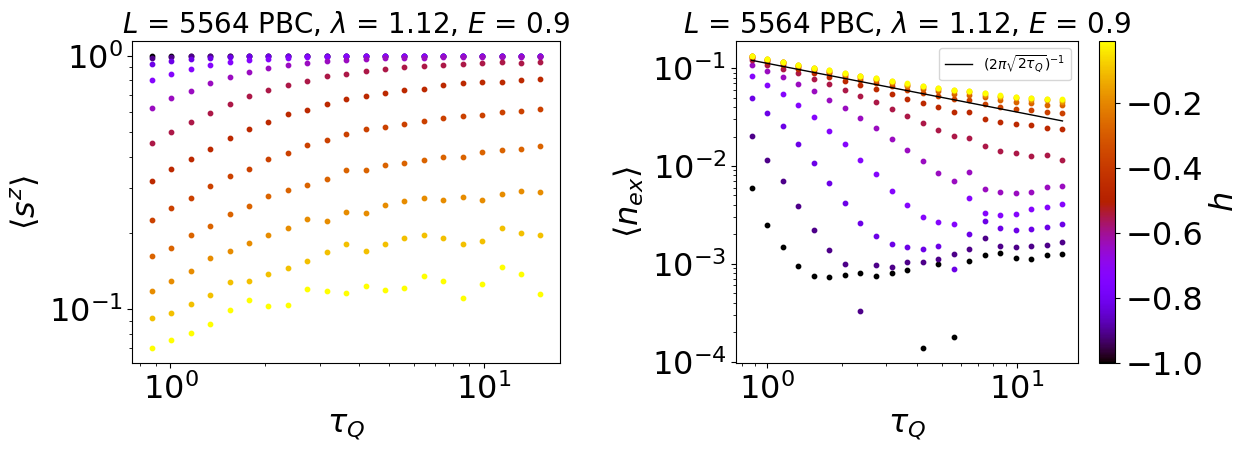

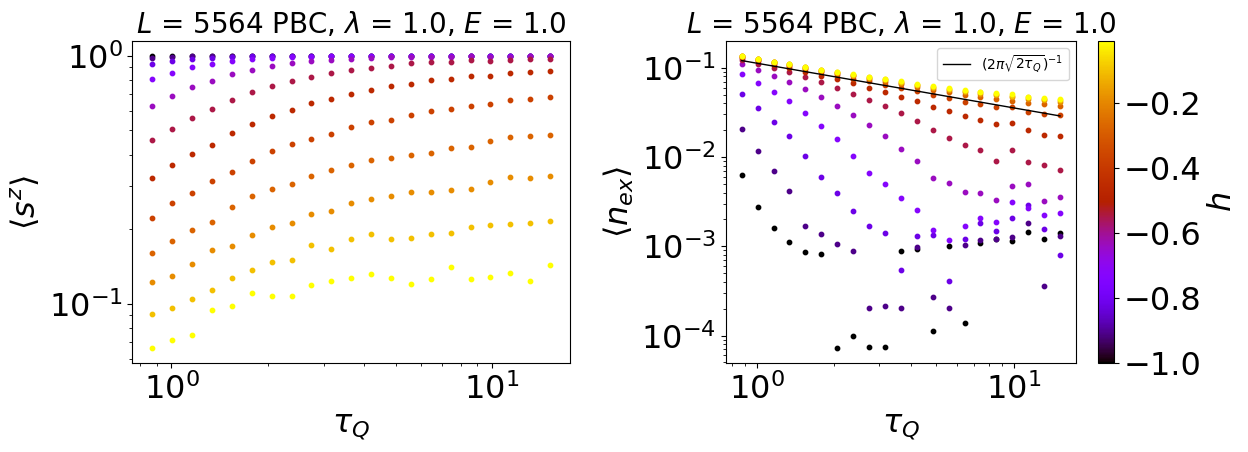

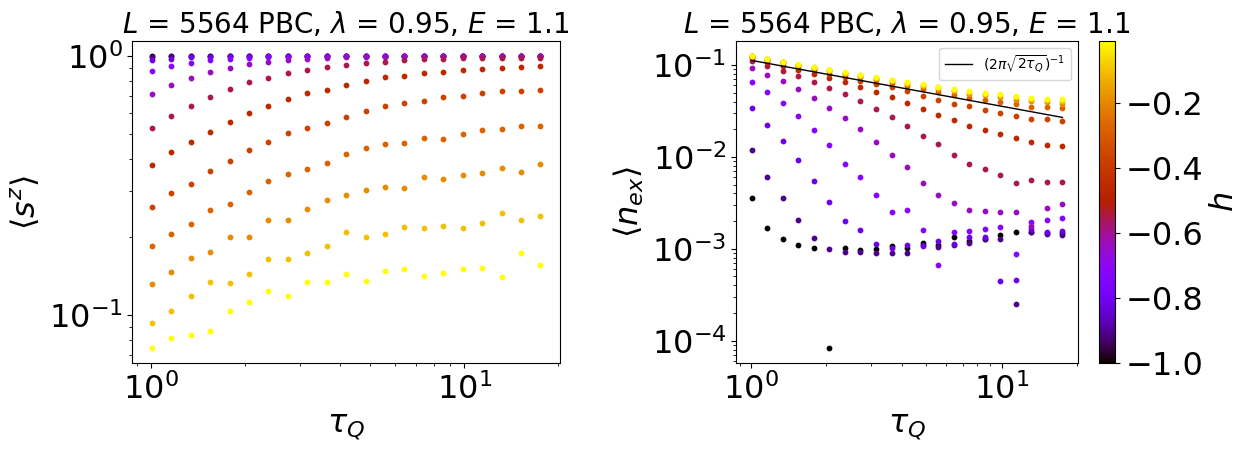

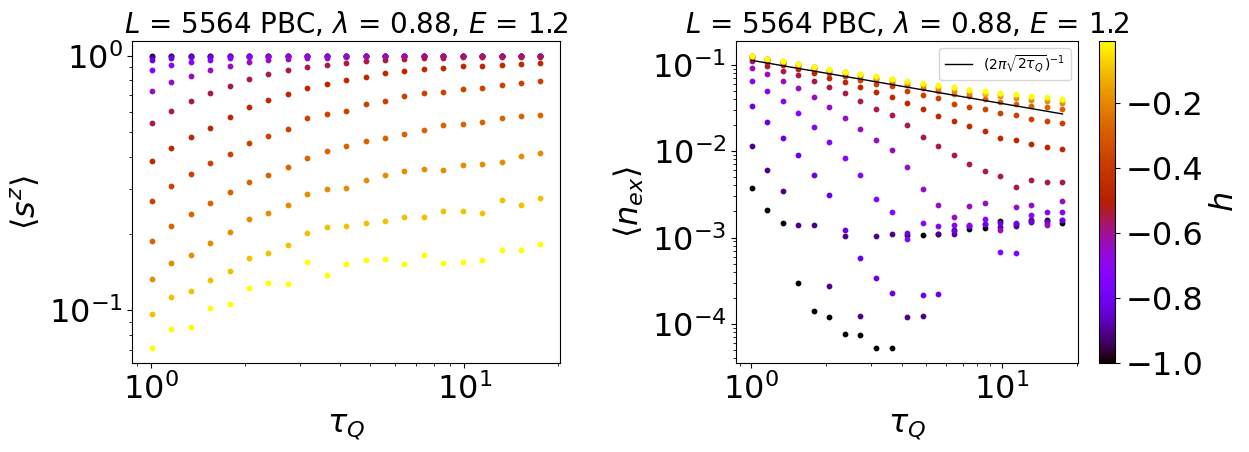

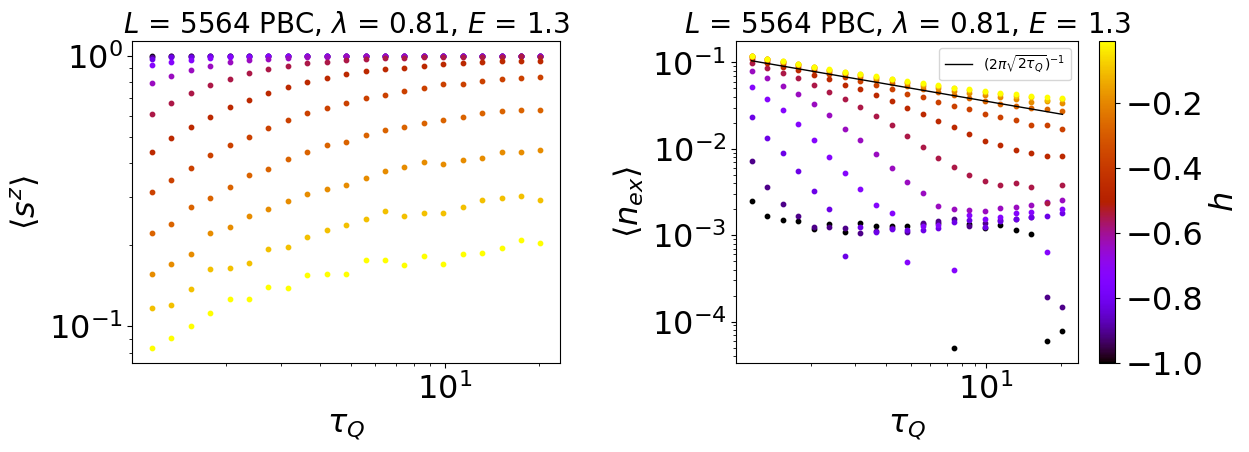

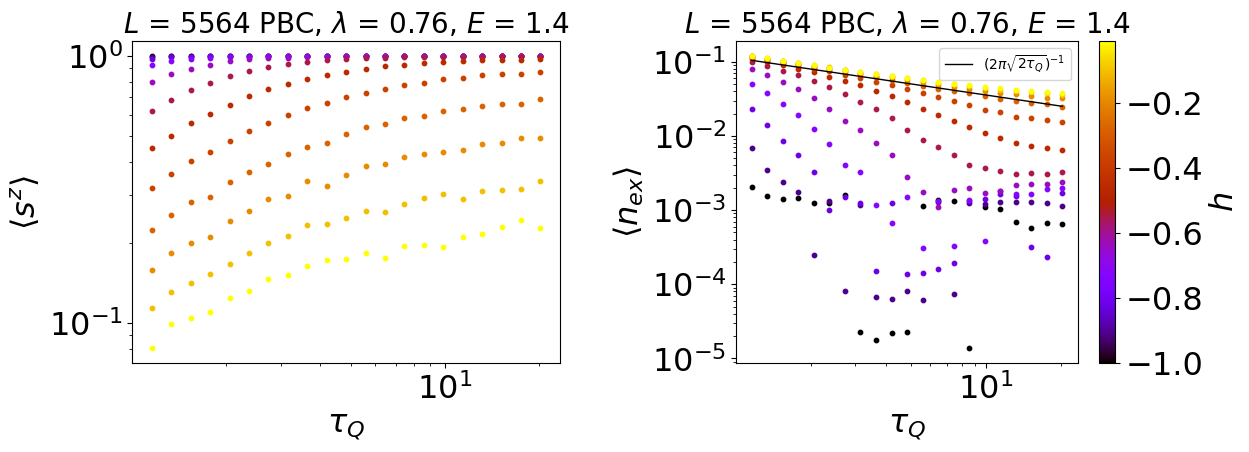

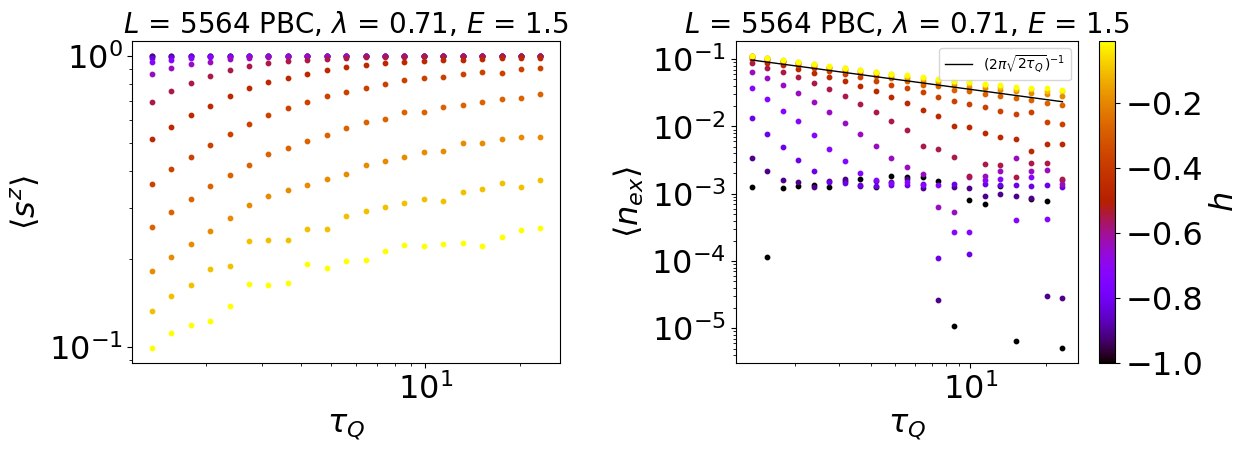

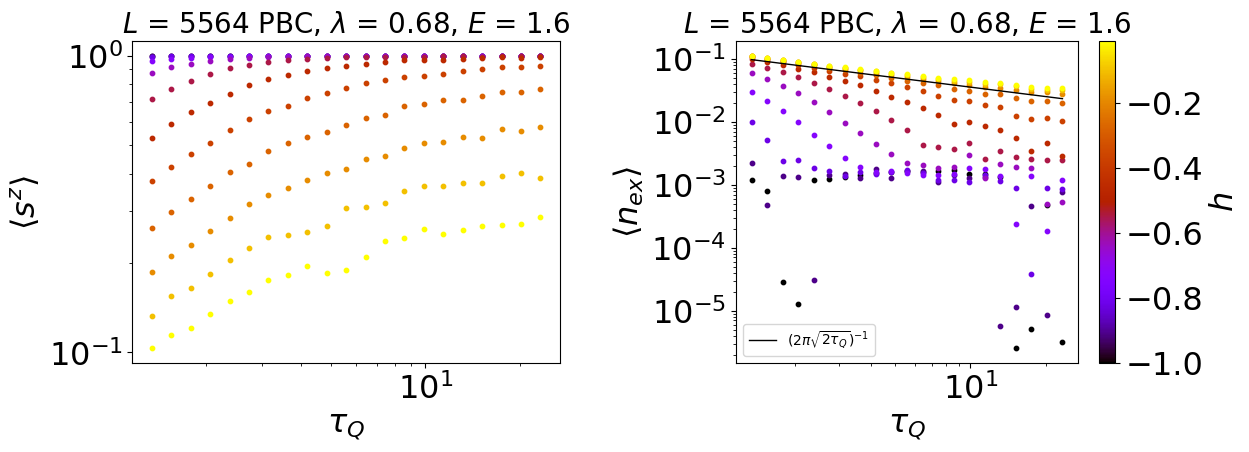

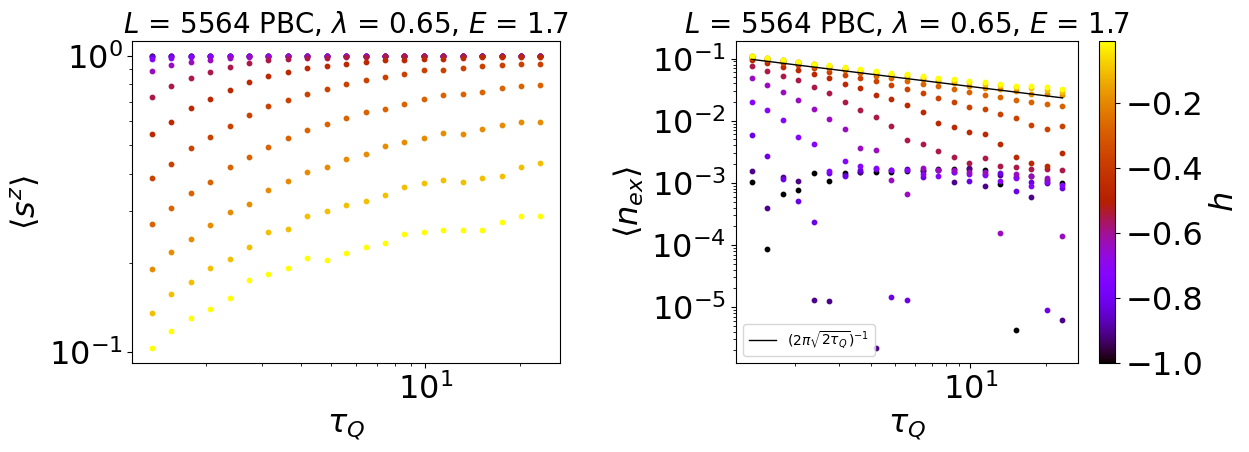

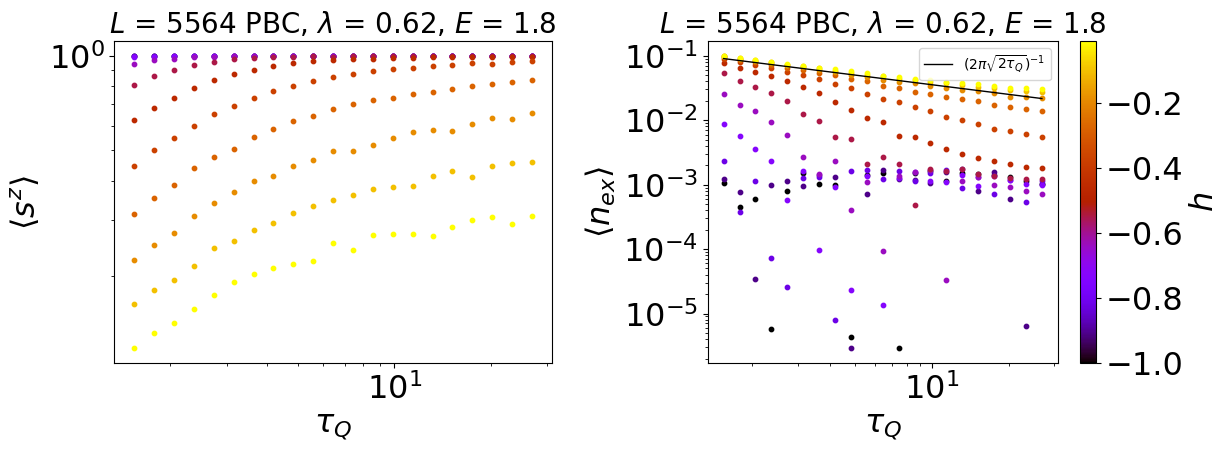

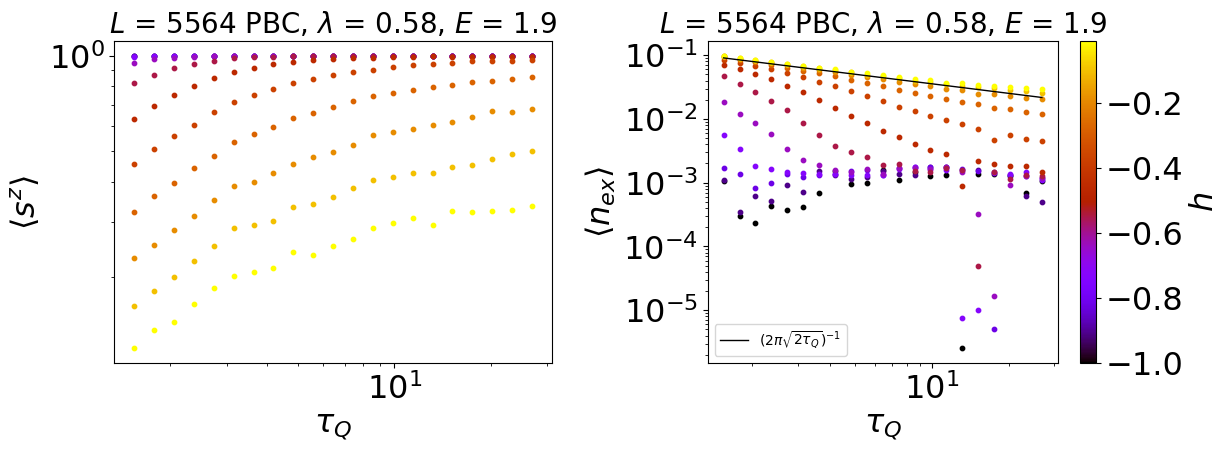

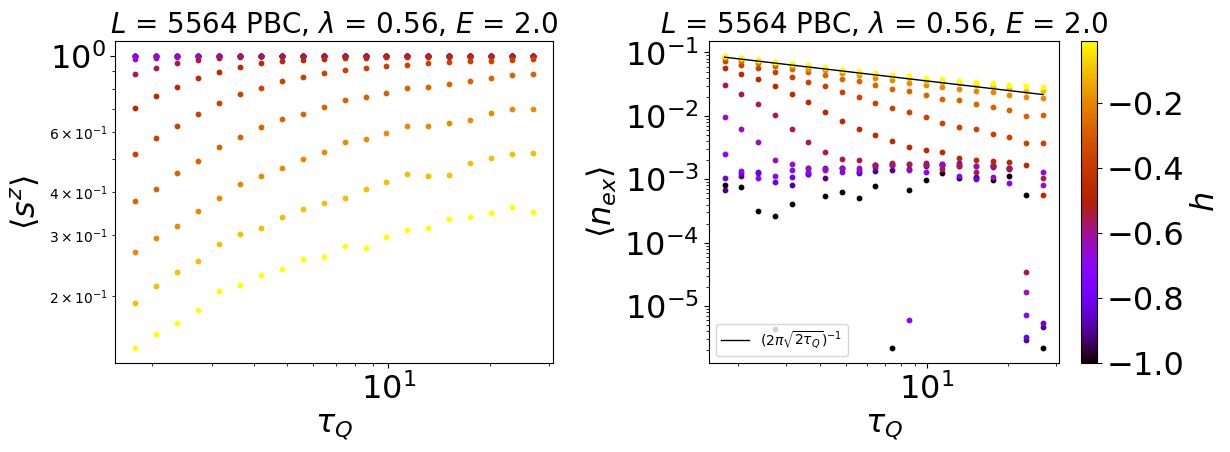

In [23]:
# PLOT RESULTS
from scipy.optimize import curve_fit

lambdas = np.array([en_to_lambda(e) for e in en_range])
third_axis = hcojcsu
third_axis_name = r'$h$'
tqs = tqsu

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(.0, 1., len(third_axis))]

lw = .5
s = 10

xmean = .15

for lamind, lam in enumerate(lambdas):
    
    xnex, ynex, xsz, ysz = np.array([]), np.array([]), np.array([]), np.array([])
    
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    
    ax[0].set_xlabel(r"$\tau_Q$", fontsize = 23)
    ax[0].tick_params(axis='x',labelsize=23)
    ax[0].tick_params(axis='y',labelsize=23)
    ax[0].set_ylabel(r"$\langle s^z\rangle$", fontsize=23)
    ax[0].set_title('$L$ = '+str(L)+r' PBC, $\lambda$ = '+str(lam.round(2))+', $E$ = '+str(en_range[lamind].round(2)), fontsize = 20)

    ax[1].set_xlabel(r"$\tau_Q$", fontsize = 23)
    ax[1].tick_params(axis='x',labelsize=23)
    ax[1].tick_params(axis='y',labelsize=23)
    ax[1].set_ylabel(r"$\langle n_{ex}\rangle$", fontsize=23)
    ax[1].set_title('$L$ = '+str(L)+r' PBC, $\lambda$ = '+str(lam.round(2))+', $E$ = '+str(en_range[lamind].round(2)), fontsize = 20)
    
    for taxind, tax in enumerate(third_axis):
        
        xtemp = []
        ysztemp = []
        ynextemp = []
        for tq in tqs:
            try:
                index = np.where(np.array(datamag[(tq,tax)])[:,0] == lam)[0]
                if len(index) > 0:
                    xtemp.append(tq)
                    ysztemp.append(np.array(datamag[(tq,tax)])[index[0],1])
                    ynextemp.append(np.array(datanex[(tq,tax)])[index[0],1])
            except:
                continue
        ysztemp = np.array(ysztemp)
        ynextemp = np.array(ynextemp)
        for indtemp, temp in enumerate(ynextemp):
            if temp > 0:
                xnex = np.concatenate((xnex,np.array([xtemp[indtemp]])))
                ynex = np.concatenate((ynex,np.array([temp])))
        for indtemp, temp in enumerate(xtemp):
            if len(ysztemp) > 0:
                if temp <= xmean and ysztemp[indtemp] > 0:
                    xsz = np.concatenate((xsz,np.array([xtemp[indtemp]])))
                    ysz = np.concatenate((ysz,np.array([ysztemp[indtemp]])))
        
        ax[0].scatter(xtemp, ysztemp, color=colors[taxind], s=s)
        ax[1].scatter(xtemp, ynextemp, color=colors[taxind], s=s)

    x = np.geomspace(xtemp[0],xtemp[-1],100)
    y = 1/(2*np.pi*np.sqrt(2*x))
    ax[1].plot(x, y, color='black', lw=2*lw, label=r'$(2\pi\sqrt{2\tau_Q})^{-1}$')
    ax[1].legend()

    fig.tight_layout(pad=2.5)
    normalize = mcolors.Normalize(vmin=min(third_axis), vmax=max(third_axis))
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
    scalarmappaple.set_array(third_axis)
    cbar = plt.colorbar(scalarmappaple, ax=ax[1])
    cbar.set_label(label=third_axis_name, size='23')
    cbar.ax.tick_params(labelsize='23')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')

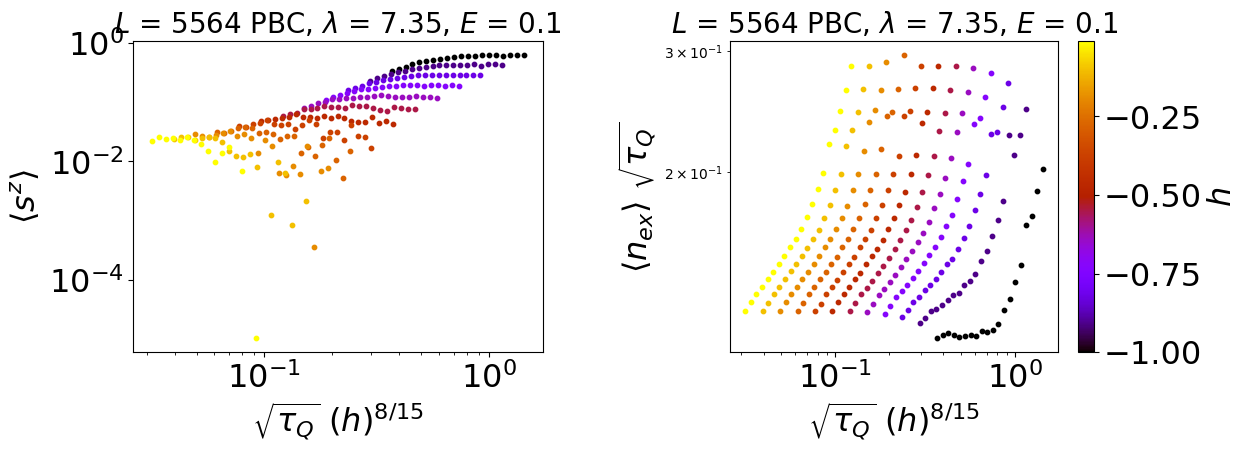

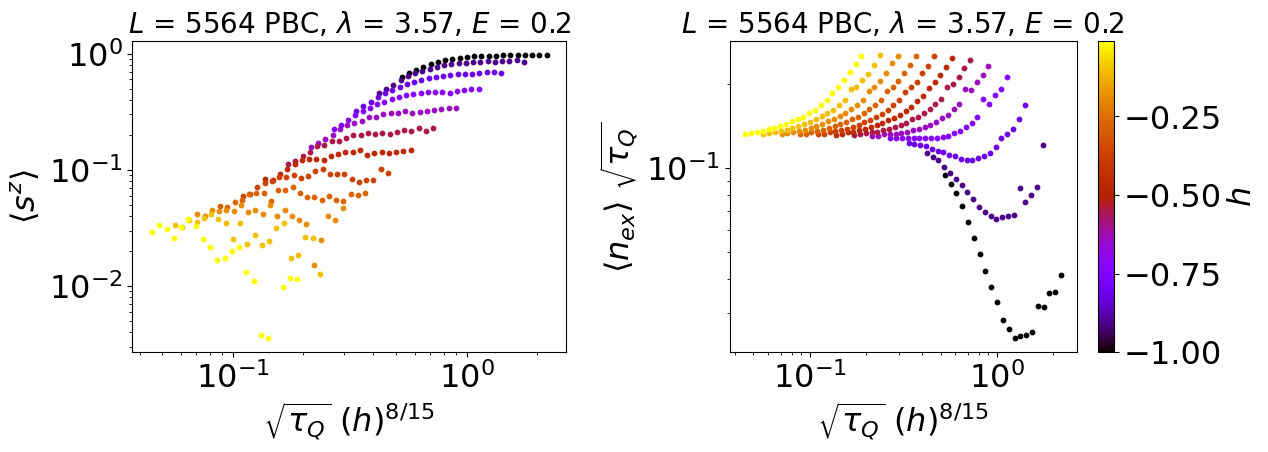

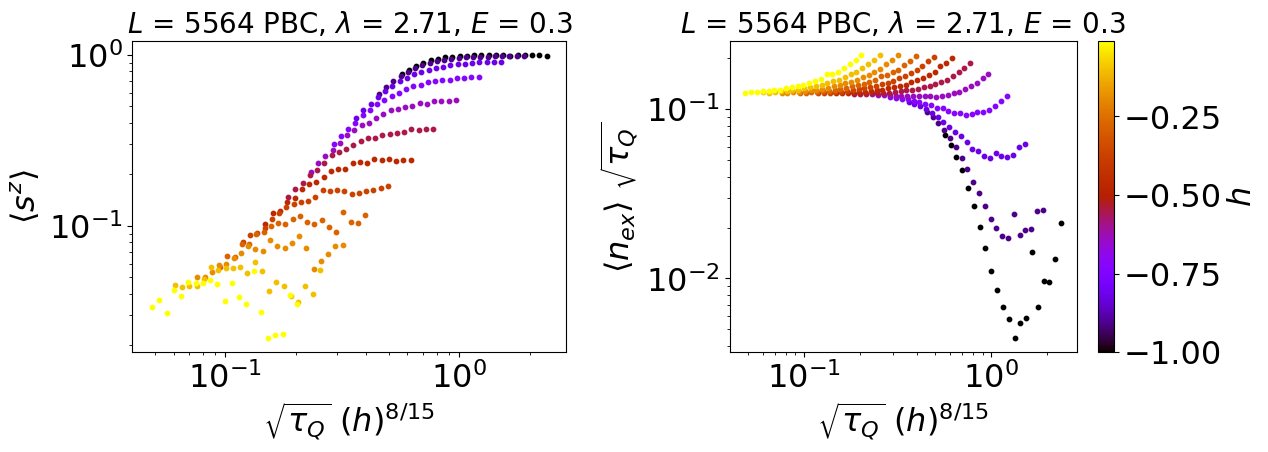

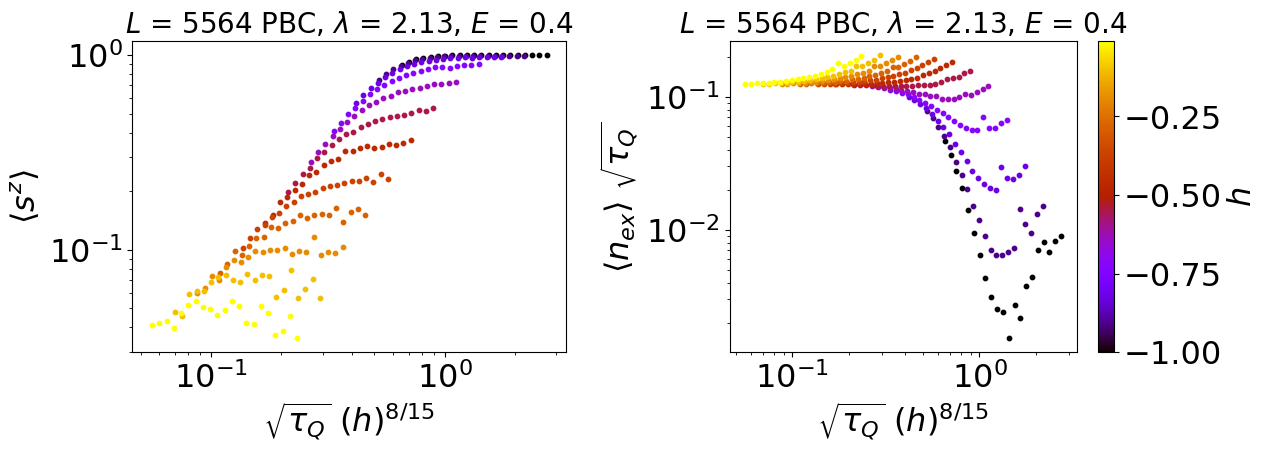

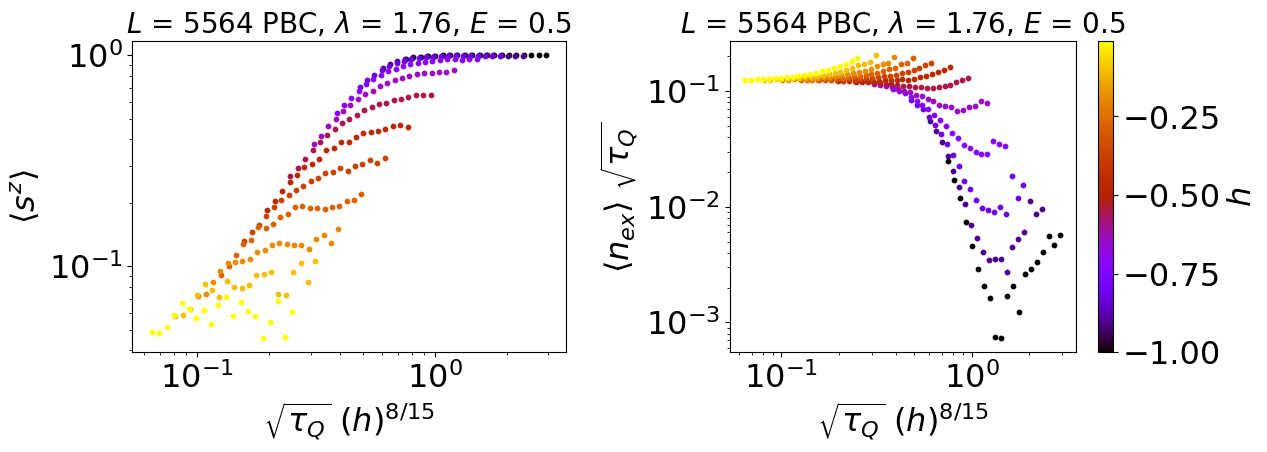

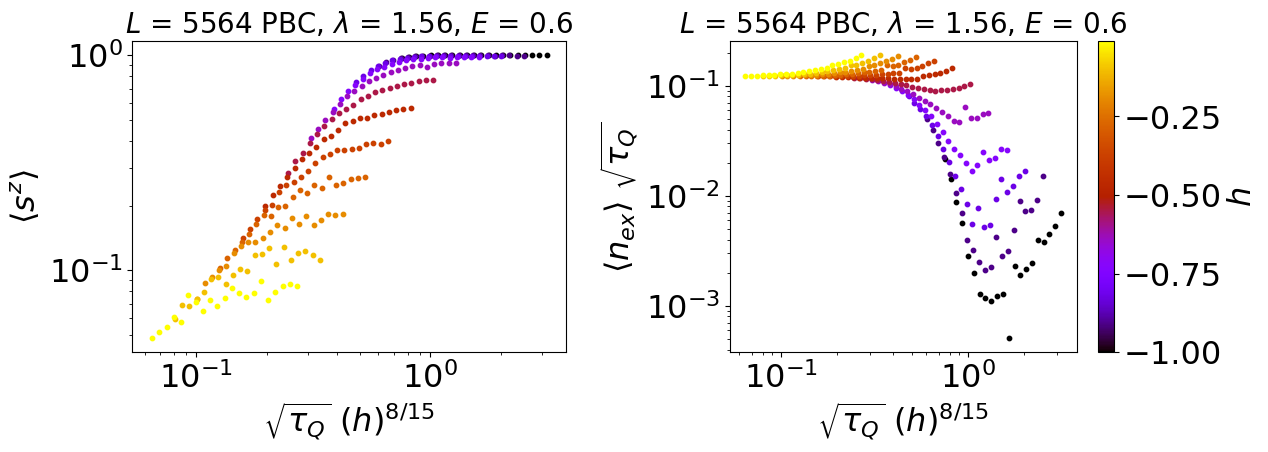

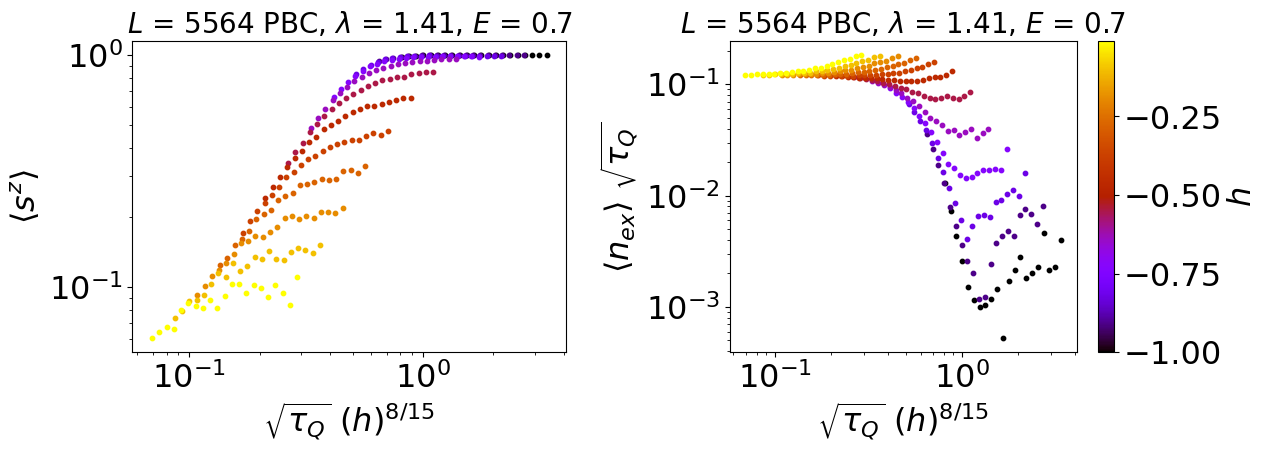

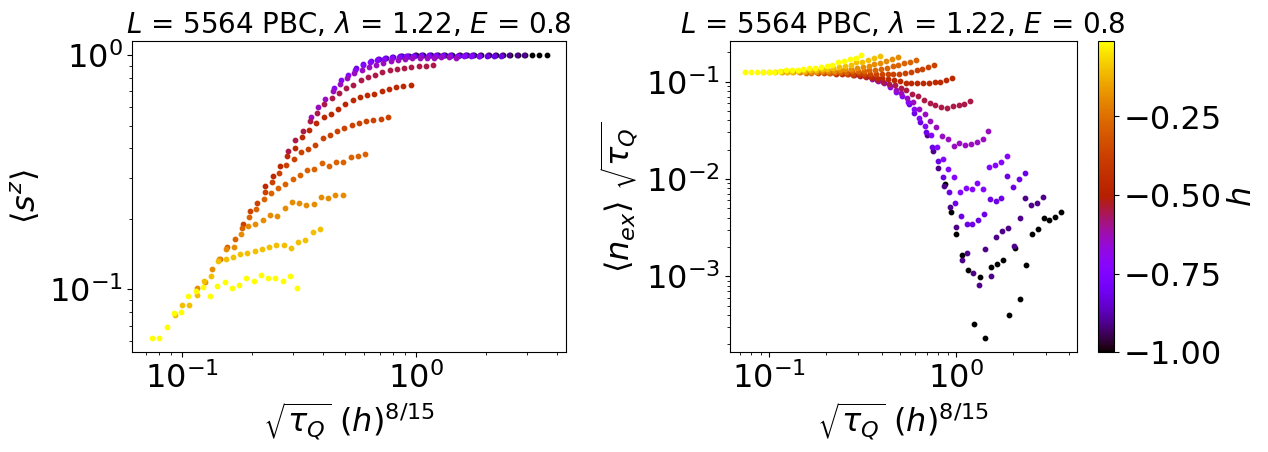

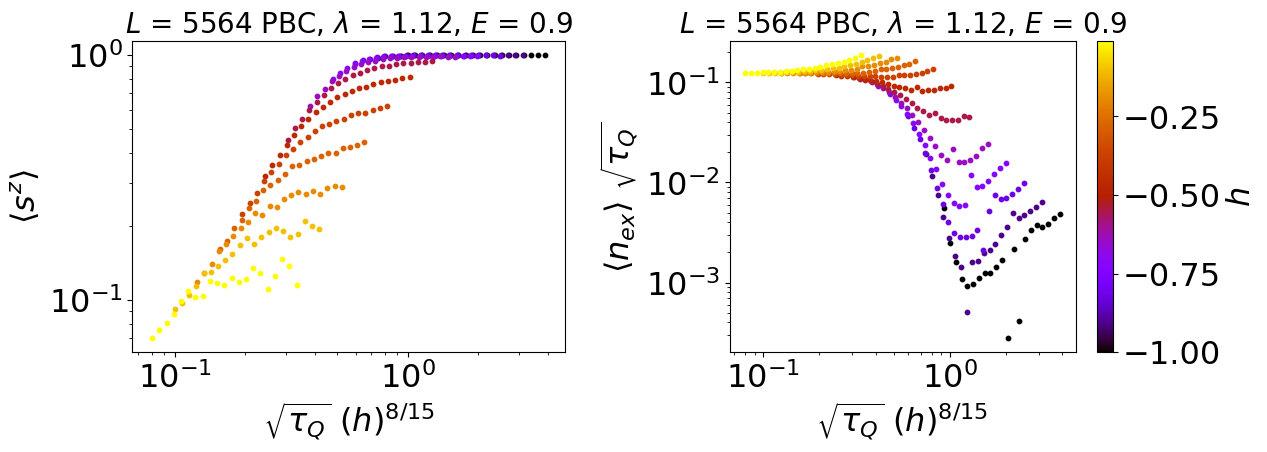

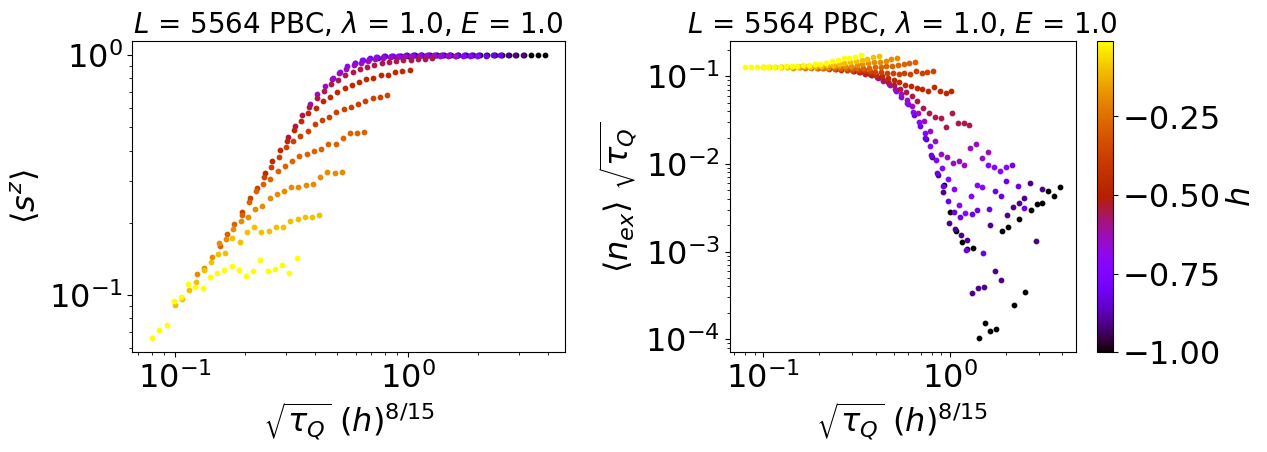

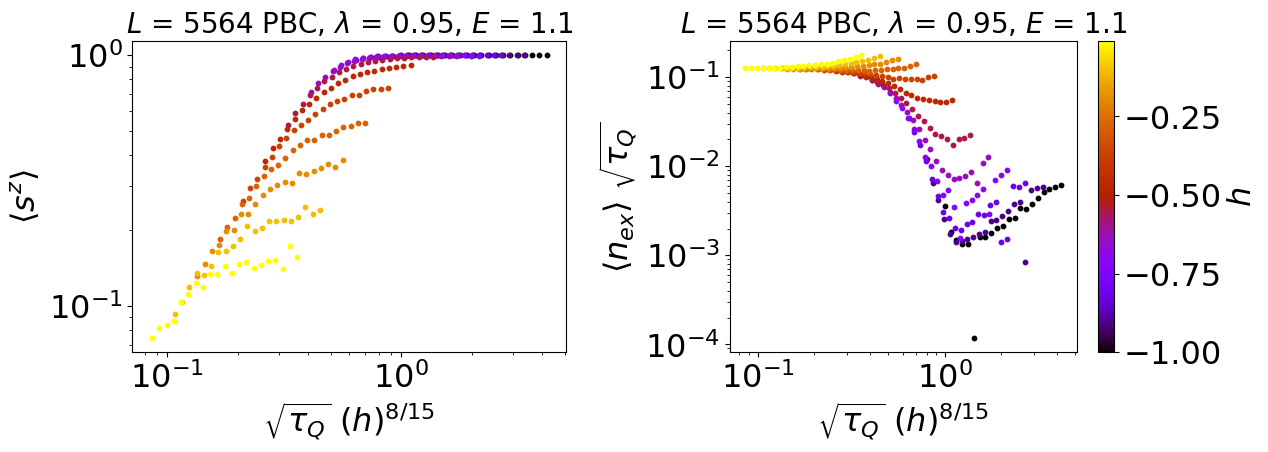

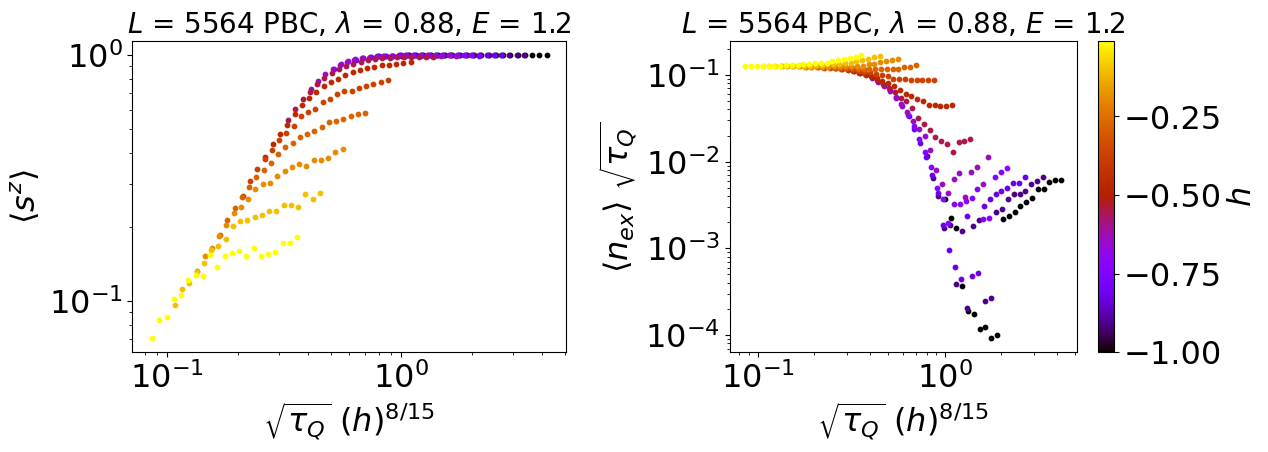

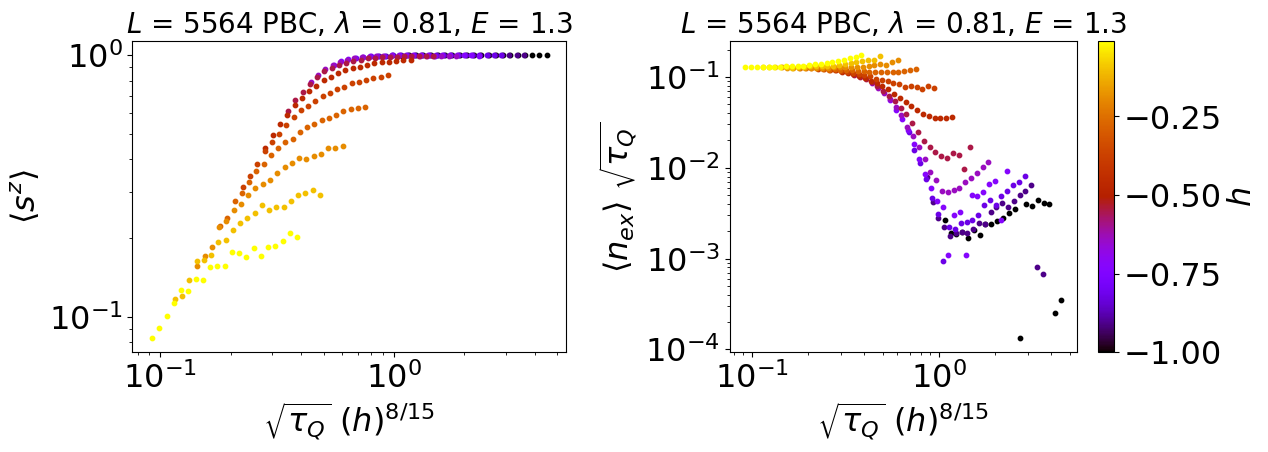

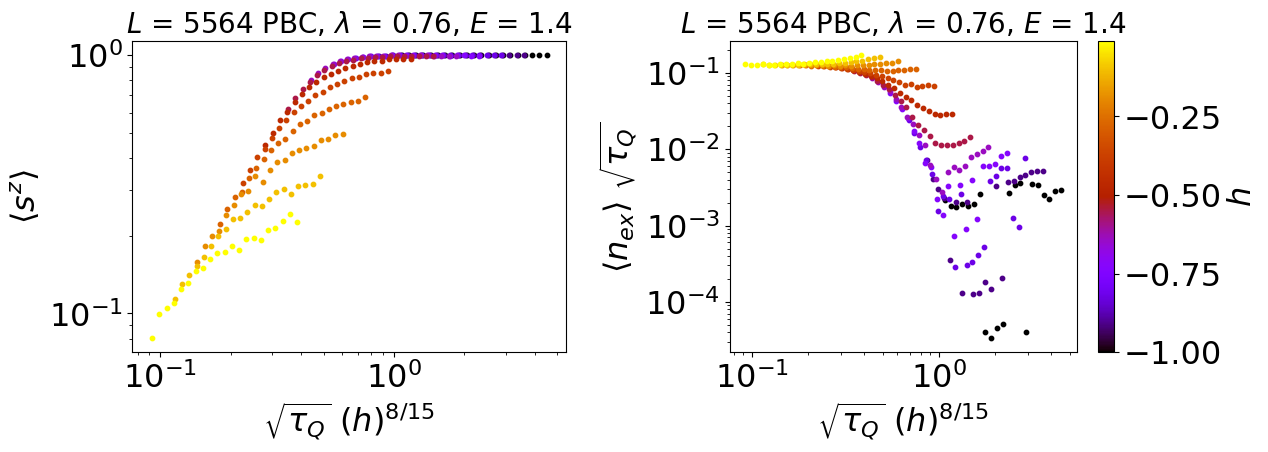

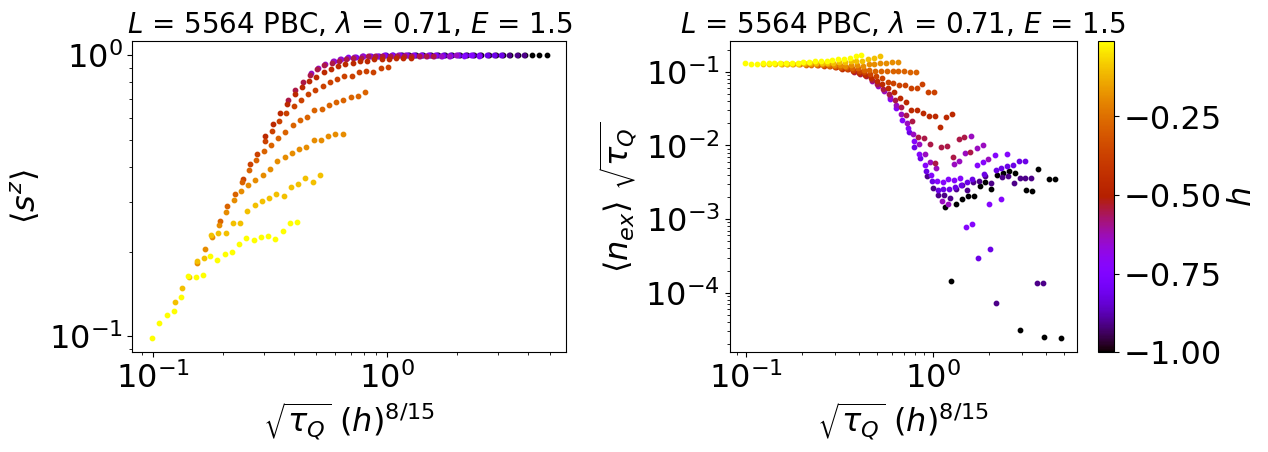

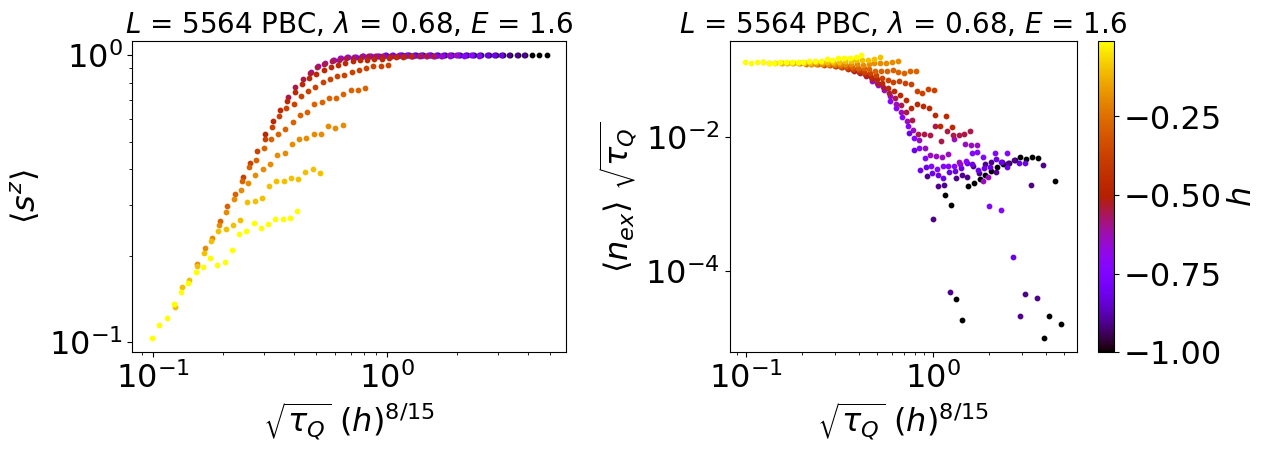

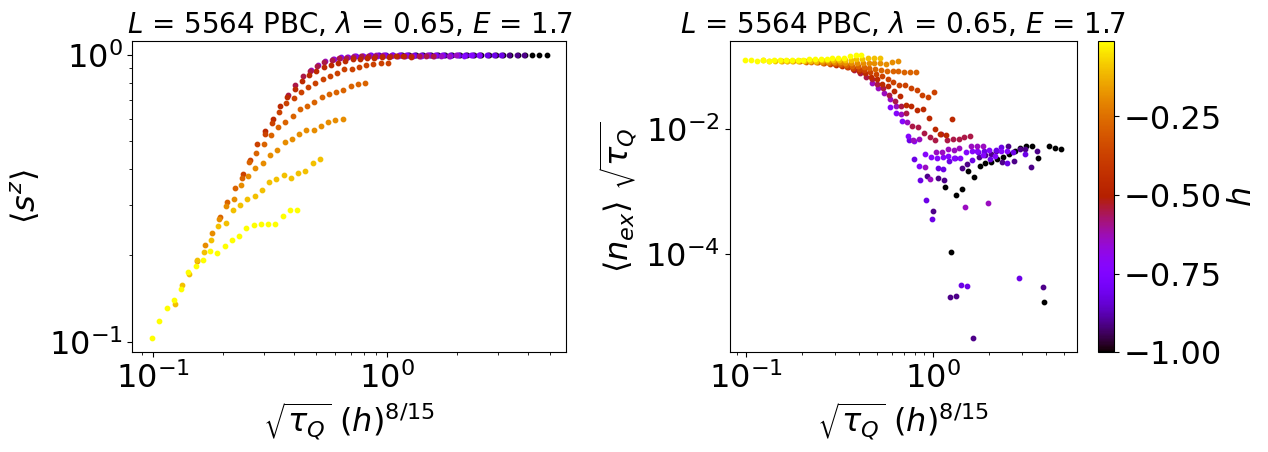

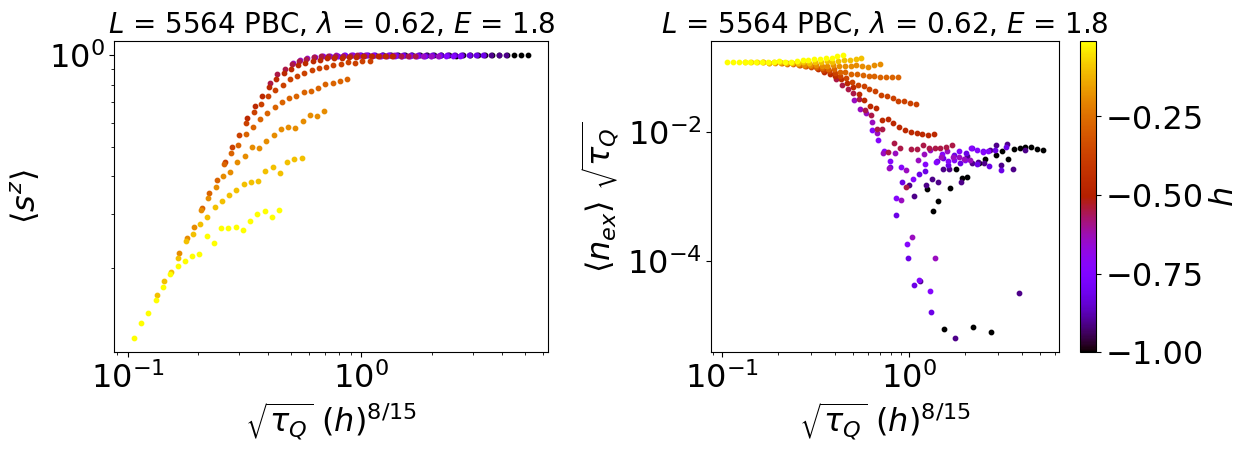

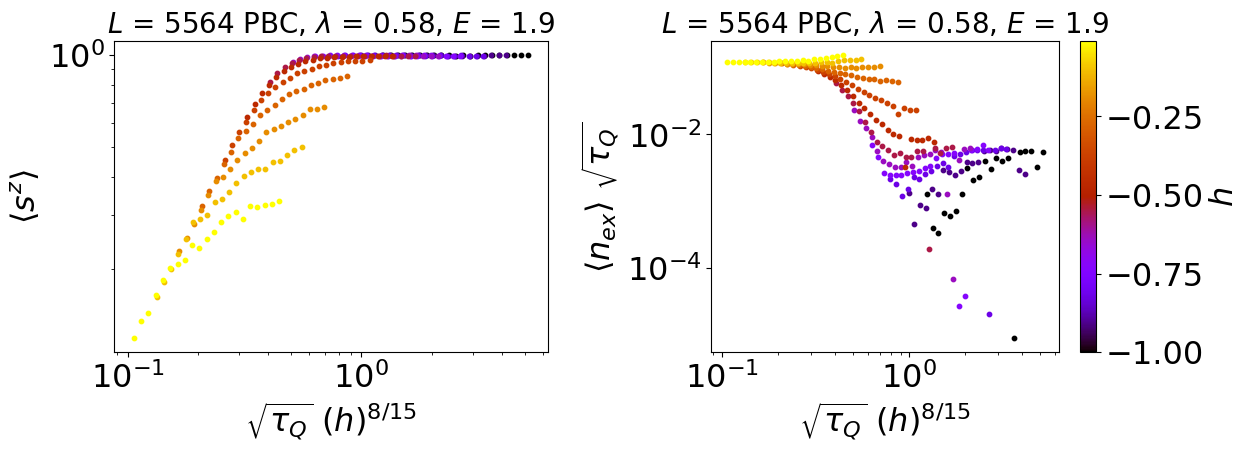

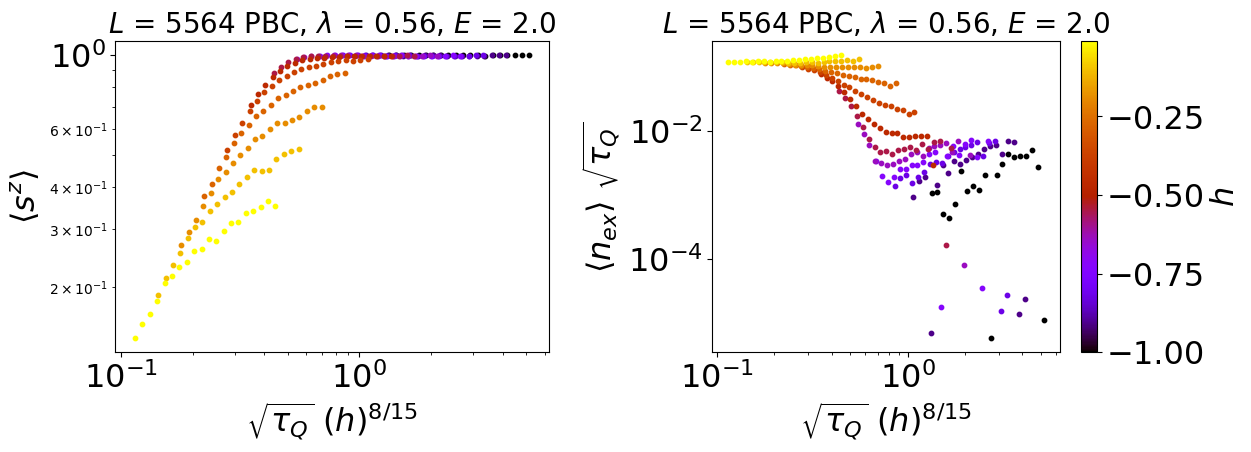

In [24]:
# PLOT RESULTS
from scipy.optimize import curve_fit

lambdas = np.array([en_to_lambda(e) for e in en_range])
third_axis = hcojcsu
third_axis_name = r'$h$'
tqs = tqsu

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(.0, 1., len(third_axis))]

lw = .5
s = 10

xmean = .15

for lamind, lam in enumerate(lambdas):
    
    xnex, ynex, xsz, ysz = np.array([]), np.array([]), np.array([]), np.array([])
    
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    
    ax[0].set_xlabel(r"$\sqrt{\tau_Q}$ $(h)^{8/15}$", fontsize = 23)
    ax[0].tick_params(axis='x',labelsize=23)
    ax[0].tick_params(axis='y',labelsize=23)
    ax[0].set_ylabel(r"$\langle s^z\rangle$", fontsize=23)
    ax[0].set_title('$L$ = '+str(L)+r' PBC, $\lambda$ = '+str(lam.round(2))+', $E$ = '+str(en_range[lamind].round(2)), fontsize = 20)

    ax[1].set_xlabel(r"$\sqrt{\tau_Q}$ $(h)^{8/15}$", fontsize = 23)
    ax[1].tick_params(axis='x',labelsize=23)
    ax[1].tick_params(axis='y',labelsize=23)
    ax[1].set_ylabel(r"$\langle n_{ex}\rangle$ $\sqrt{\tau_Q}$", fontsize=23)
    ax[1].set_title('$L$ = '+str(L)+r' PBC, $\lambda$ = '+str(lam.round(2))+', $E$ = '+str(en_range[lamind].round(2)), fontsize = 20)
    
    for taxind, tax in enumerate(third_axis):
        
        xtemp = []
        ysztemp = []
        ynextemp = []
        for tq in tqs:
            try:
                index = np.where(np.array(datamag[(tq,tax)])[:,0] == lam)[0]
                if len(index) > 0:
                    xtemp.append(np.sqrt(tq)*abs(tax)**(8/15))
                    ysztemp.append(np.array(datamag[(tq,tax)])[index[0],1])
                    ynextemp.append(np.sqrt(tq)*np.array(datanex[(tq,tax)])[index[0],1])
            except:
                continue
        ysztemp = np.array(ysztemp)
        ynextemp = np.array(ynextemp)
        for indtemp, temp in enumerate(ynextemp):
            if temp > 0:
                xnex = np.concatenate((xnex,np.array([xtemp[indtemp]])))
                ynex = np.concatenate((ynex,np.array([temp])))
        for indtemp, temp in enumerate(xtemp):
            if len(ysztemp) > 0:
                if temp <= xmean and ysztemp[indtemp] > 0:
                    xsz = np.concatenate((xsz,np.array([xtemp[indtemp]])))
                    ysz = np.concatenate((ysz,np.array([ysztemp[indtemp]])))
        
        ax[0].scatter(xtemp, ysztemp, color=colors[taxind], s=s)
        ax[1].scatter(xtemp, ynextemp, color=colors[taxind], s=s)

    fig.tight_layout(pad=2.5)
    normalize = mcolors.Normalize(vmin=min(third_axis), vmax=max(third_axis))
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
    scalarmappaple.set_array(third_axis)
    cbar = plt.colorbar(scalarmappaple, ax=ax[1])
    cbar.set_label(label=third_axis_name, size='23')
    cbar.ax.tick_params(labelsize='23')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')

# 2D

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from collections import Counter
import dimod
import pickle
import lzma
import pandas as pd
import gzip
import os
from random import randrange

In [26]:
nos = 2436
Lx = 42
Ly = 29
J = -1.
num_reads = 1000

In [27]:
#Import results from D-Wave - Needed for the code below to work!
analysis_results_dir = 'D_Wave_data_dicts/'

with gzip.open(os.path.join(analysis_results_dir, '2D_tfim_6th_sweep_mag.txt.gz'), "rt") as f:
    fvd_mags = eval(f.read().replace('nan','np.nan'))

# Dictionary of filenames to variable names
files_and_vars = {
    'xisfromGx.pkl':    'xis_Gx_dict',
    'xisfromGy.pkl':    'xis_Gy_dict',
    'xisfromGdiag.pkl': 'xis_Gdiag_dict',
    'xisfromSx.pkl':    'xis_Sx_dict',
    'xisfromSy.pkl':    'xis_Sy_dict',
    'xisfromSdiag.pkl': 'xis_Sdiag_dict',
    'S0sfromSx.pkl':    'S0_Sx_dict',
    'S0sfromSy.pkl':    'S0_Sy_dict',
    'S0sfromSdiag.pkl': 'S0_Sdiag_dict',
}

# Load each pickle into the current namespace
for filename, varname in files_and_vars.items():
    path = os.path.join(analysis_results_dir, filename)
    with open(path, 'rb') as f:
        globals()[varname] = pickle.load(f)

In [28]:
# Parameters at lambda = 0.5
lambdas = [.5]
ens = [2.]
hs = [-.01, -0.053367, -.123285]
tas = [.005549, .006412, .00741, .008562, .009894]

In [29]:
#Exporting results from D-Wave - this only work on my computer because I have the raw data
results_dir = 'C:/Users/jakav/Desktop/IJS/D-Wave/FastAnnealing/QuantumAnnealer/Results/Results-6th-sweep/'
print(r'$\lambda$','$E$','$h$','$t_a$')
for enind, en in enumerate(ens):
    for hind, h in enumerate(hs):
        for taind, ta in enumerate(tas):
            f = '2D_TFIM_nos_2436_Lx_42_Ly_29_J_-1_0_hz_'+str(h).replace('.','_')+'_ta_'+str(ta).replace('.','_')+'_en_'+str(en).replace('.','_')+'_nr_1000_emb_sl54PBCish_LQ_2436_PQ_2436_fa_True_am_raw_as_False.txt'
            results = dimod.SampleSet.from_serializable(pickle.load(lzma.open(results_dir + f,'rb'))).to_pandas_dataframe().to_numpy()
            print(lambdas[enind],ens[enind],h,ta)
            with open('results_lambda_'+str(lambdas[enind]).replace('.','_')+'_h_'+str(h).replace('.','_')+'_ta_'+str(ta).replace('.','_')+'.npy', 'wb') as f:
                np.save(f, results)

$\lambda$ $E$ $h$ $t_a$
0.5 2.0 -0.01 0.005549
0.5 2.0 -0.01 0.006412
0.5 2.0 -0.01 0.00741
0.5 2.0 -0.01 0.008562
0.5 2.0 -0.01 0.009894
0.5 2.0 -0.053367 0.005549
0.5 2.0 -0.053367 0.006412
0.5 2.0 -0.053367 0.00741
0.5 2.0 -0.053367 0.008562
0.5 2.0 -0.053367 0.009894
0.5 2.0 -0.123285 0.005549
0.5 2.0 -0.123285 0.006412
0.5 2.0 -0.123285 0.00741
0.5 2.0 -0.123285 0.008562
0.5 2.0 -0.123285 0.009894


In [30]:
# --- System parameters ---
Lx, Ly, J = 42, 29, -1.

# --- Load interaction dictionary ---
J_dict_keys = eval(open(f'square-lattice-PBCish-{Lx}x{Ly}x2-native-5.4-{2*Lx*Ly}-J_dict-keys.txt', 'r').read())
J_dict = {key: J for key in J_dict_keys}

# --- Header for table-like output ---
header = (
    f"{'λ':>8} | {'E':>6} | {'hz':>6} | {'ta (μs)':>9} | {'Energy/spin':>13} | "
    f"{'⟨M⟩':>10} | {'Domains/spin':>15} | {'ξ (sqrt⟨A⟩)':>12} | "
    f"{'ξ_Gx':>8} | {'ξ_Gy':>8} | {'ξ_Gd':>8} | {'ξ_Sx':>8} | {'ξ_Sy':>8} | {'ξ_Sd':>8}"
)
print(header)
print("-" * len(header))

# --- Loop over parameters and present results ---
for enind, en in enumerate(ens):
    lam = lambdas[enind]
    for hind, h in enumerate(hs):
        for taind, ta in enumerate(tas):
            # Load spin configurations
            filename = f"results_lambda_{str(lam).replace('.', '_')}_h_{str(h).replace('.', '_')}_ta_{str(ta).replace('.', '_')}.npy"
            results = np.load(filename)
            data = results[:, :-3]

            # Energy per spin
            E_spins = (
                np.sum([J_dict[q] * data[:, q[0]] * data[:, q[1]] for q in J_dict.keys()], axis=0)
                + h * np.sum(data, axis=1)
            ) / (2 * Lx * Ly)
            E_avg = E_spins.mean()

            # Magnetization
            M_avg = np.mean(data)

            # Domain stats from FVD analysis
            nex_per_spin = fvd_mags[(nos, Lx, Ly, J, h, ta, en, num_reads, 'nexmean')] / nos
            xi_fvd = np.sqrt(fvd_mags[(nos, Lx, Ly, J, h, ta, en, num_reads, 'domainsizemean')] / nos)

            # Key for correlation dictionaries
            key = (en, h, ta)

            # Retrieve ξ from each dictionary
            xi_Gx   = xis_Gx_dict.get(key, np.nan)
            xi_Gy   = xis_Gy_dict.get(key, np.nan)
            xi_Gdiag= xis_Gdiag_dict.get(key, np.nan)
            xi_Sx   = xis_Sx_dict.get(key, np.nan)
            xi_Sy   = xis_Sy_dict.get(key, np.nan)
            xi_Sdiag= xis_Sdiag_dict.get(key, np.nan)

            # Print row with all values
            print(f"{lam:8.4f} | {en:6.3f} | {h:6.3f} | {ta:9.6f} | {E_avg:13.5f} | "
                  f"{M_avg:10.5f} | {nex_per_spin:15.5f} | {xi_fvd:12.5f} | "
                  f"{xi_Gx:8.5f} | {xi_Gy:8.5f} | {xi_Gdiag:8.5f} | "
                  f"{xi_Sx:8.5f} | {xi_Sy:8.5f} | {xi_Sdiag:8.5f}")


       λ |      E |     hz |   ta (μs) |   Energy/spin |        ⟨M⟩ |    Domains/spin |  ξ (sqrt⟨A⟩) |     ξ_Gx |     ξ_Gy |     ξ_Gd |     ξ_Sx |     ξ_Sy |     ξ_Sd
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
  0.5000 |  2.000 | -0.010 |  0.005549 |      -1.70539 |    0.31674 |         0.00405 |      0.20527 |  4.15572 |  3.84069 |  2.77259 |  6.20338 |  6.12723 |  4.36893
  0.5000 |  2.000 | -0.010 |  0.006412 |      -1.73387 |    0.33604 |         0.00349 |      0.21851 |  4.54882 |  4.21828 |  3.03321 |  6.66173 |  6.69236 |  4.66243
  0.5000 |  2.000 | -0.010 |  0.007410 |      -1.76386 |    0.39361 |         0.00301 |      0.23133 |  4.86093 |  4.56733 |  3.28876 |  6.99366 |  7.02358 |  4.89252
  0.5000 |  2.000 | -0.010 |  0.008562 |      -1.79325 |    0.46125 |         0.00257 |      0.24128 |  5.30856 |  5.00844 |  3.55787 |  7.47295 |  7.16749 |  5.0450

In [31]:
# Parameters at lambda = 1.0
lambdas = [1.]
ens = [1.]
hs = [-.01, -0.053367, -.123285]
tas = [.005378, .006215, .007182, .008299, .00959]

In [32]:
#Exporting results from D-Wave - this only work on my computer because I have the raw data
print(r'$\lambda$','$E$','$h$','$t_a$')
results_dir = 'C:/Users/jakav/Desktop/IJS/D-Wave/FastAnnealing/QuantumAnnealer/Results/Results-6th-sweep/'
for enind, en in enumerate(ens):
    for hind, h in enumerate(hs):
        for taind, ta in enumerate(tas):
            f = '2D_TFIM_nos_2436_Lx_42_Ly_29_J_-1_0_hz_'+str(h).replace('.','_')+'_ta_'+str(ta).replace('.','_')+'_en_'+str(en).replace('.','_')+'_nr_1000_emb_sl54PBCish_LQ_2436_PQ_2436_fa_True_am_raw_as_False.txt'
            results = dimod.SampleSet.from_serializable(pickle.load(lzma.open(results_dir + f,'rb'))).to_pandas_dataframe().to_numpy()
            print(lambdas[enind],ens[enind],h,ta)
            with open('results_lambda_'+str(lambdas[enind]).replace('.','_')+'_h_'+str(h).replace('.','_')+'_ta_'+str(ta).replace('.','_')+'.npy', 'wb') as f:
                np.save(f, results)

$\lambda$ $E$ $h$ $t_a$
1.0 1.0 -0.01 0.005378
1.0 1.0 -0.01 0.006215
1.0 1.0 -0.01 0.007182
1.0 1.0 -0.01 0.008299
1.0 1.0 -0.01 0.00959
1.0 1.0 -0.053367 0.005378
1.0 1.0 -0.053367 0.006215
1.0 1.0 -0.053367 0.007182
1.0 1.0 -0.053367 0.008299
1.0 1.0 -0.053367 0.00959
1.0 1.0 -0.123285 0.005378
1.0 1.0 -0.123285 0.006215
1.0 1.0 -0.123285 0.007182
1.0 1.0 -0.123285 0.008299
1.0 1.0 -0.123285 0.00959


In [33]:
# --- System parameters ---
Lx, Ly, J = 42, 29, -1.

# --- Load interaction dictionary ---
J_dict_keys = eval(open(f'square-lattice-PBCish-{Lx}x{Ly}x2-native-5.4-{2*Lx*Ly}-J_dict-keys.txt', 'r').read())
J_dict = {key: J for key in J_dict_keys}

# --- Header for table-like output ---
header = (
    f"{'λ':>8} | {'E':>6} | {'hz':>6} | {'ta (μs)':>9} | {'Energy/spin':>13} | "
    f"{'⟨M⟩':>10} | {'Domains/spin':>15} | {'ξ (sqrt⟨A⟩)':>12} | "
    f"{'ξ_Gx':>8} | {'ξ_Gy':>8} | {'ξ_Gd':>8} | {'ξ_Sx':>8} | {'ξ_Sy':>8} | {'ξ_Sd':>8}"
)
print(header)
print("-" * len(header))

# --- Loop over parameters and present results ---
for enind, en in enumerate(ens):
    lam = lambdas[enind]
    for hind, h in enumerate(hs):
        for taind, ta in enumerate(tas):
            # Load spin configurations
            filename = f"results_lambda_{str(lam).replace('.', '_')}_h_{str(h).replace('.', '_')}_ta_{str(ta).replace('.', '_')}.npy"
            results = np.load(filename)
            data = results[:, :-3]

            # Energy per spin
            E_spins = (
                np.sum([J_dict[q] * data[:, q[0]] * data[:, q[1]] for q in J_dict.keys()], axis=0)
                + h * np.sum(data, axis=1)
            ) / (2 * Lx * Ly)
            E_avg = E_spins.mean()

            # Magnetization
            M_avg = np.mean(data)

            # Domain stats from FVD analysis
            nex_per_spin = fvd_mags[(nos, Lx, Ly, J, h, ta, en, num_reads, 'nexmean')] / nos
            xi_fvd = np.sqrt(fvd_mags[(nos, Lx, Ly, J, h, ta, en, num_reads, 'domainsizemean')] / nos)

            # Key for correlation dictionaries
            key = (en, h, ta)

            # Retrieve ξ from each dictionary
            xi_Gx   = xis_Gx_dict.get(key, np.nan)
            xi_Gy   = xis_Gy_dict.get(key, np.nan)
            xi_Gdiag= xis_Gdiag_dict.get(key, np.nan)
            xi_Sx   = xis_Sx_dict.get(key, np.nan)
            xi_Sy   = xis_Sy_dict.get(key, np.nan)
            xi_Sdiag= xis_Sdiag_dict.get(key, np.nan)

            # Print row with all values
            print(f"{lam:8.4f} | {en:6.3f} | {h:6.3f} | {ta:9.6f} | {E_avg:13.5f} | "
                  f"{M_avg:10.5f} | {nex_per_spin:15.5f} | {xi_fvd:12.5f} | "
                  f"{xi_Gx:8.5f} | {xi_Gy:8.5f} | {xi_Gdiag:8.5f} | "
                  f"{xi_Sx:8.5f} | {xi_Sy:8.5f} | {xi_Sdiag:8.5f}")


       λ |      E |     hz |   ta (μs) |   Energy/spin |        ⟨M⟩ |    Domains/spin |  ξ (sqrt⟨A⟩) |     ξ_Gx |     ξ_Gy |     ξ_Gd |     ξ_Sx |     ξ_Sy |     ξ_Sd
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
  1.0000 |  1.000 | -0.010 |  0.005378 |      -1.45490 |    0.13351 |         0.00592 |      0.17856 |  2.49087 |  2.35902 |  1.71807 |  4.22963 |  4.18762 |  3.14276
  1.0000 |  1.000 | -0.010 |  0.006215 |      -1.50135 |    0.15055 |         0.00507 |      0.19338 |  2.72015 |  2.58093 |  1.85604 |  4.53606 |  4.49395 |  3.33700
  1.0000 |  1.000 | -0.010 |  0.007182 |      -1.53545 |    0.16621 |         0.00498 |      0.19294 |  2.93899 |  2.81173 |  2.01540 |  4.82183 |  4.74644 |  3.57295
  1.0000 |  1.000 | -0.010 |  0.008299 |      -1.57499 |    0.18206 |         0.00480 |      0.19283 |  3.21255 |  3.08865 |  2.18541 |  5.11931 |  5.07688 |  3.7451

In [34]:
# Parameters at lambda = 1.0
lambdas = [1.87]
ens = [.5]
hs = [-.01, -0.053367, -.123285]
tas = [.005637, .006514, .007527, .008698, .010051]

In [35]:
#Exporting results from D-Wave - this only work on my computer because I have the raw data
print(r'$\lambda$','$E$','$h$','$t_a$')
results_dir = 'C:/Users/jakav/Desktop/IJS/D-Wave/FastAnnealing/QuantumAnnealer/Results/Results-6th-sweep/'
for enind, en in enumerate(ens):
    for hind, h in enumerate(hs):
        for taind, ta in enumerate(tas):
            f = '2D_TFIM_nos_2436_Lx_42_Ly_29_J_-1_0_hz_'+str(h).replace('.','_')+'_ta_'+str(ta).replace('.','_')+'_en_'+str(en).replace('.','_')+'_nr_1000_emb_sl54PBCish_LQ_2436_PQ_2436_fa_True_am_raw_as_False.txt'
            results = dimod.SampleSet.from_serializable(pickle.load(lzma.open(results_dir + f,'rb'))).to_pandas_dataframe().to_numpy()
            print(lambdas[enind],ens[enind],h,ta)
            with open('results_lambda_'+str(lambdas[enind]).replace('.','_')+'_h_'+str(h).replace('.','_')+'_ta_'+str(ta).replace('.','_')+'.npy', 'wb') as f:
                np.save(f, results)

$\lambda$ $E$ $h$ $t_a$
1.87 0.5 -0.01 0.005637
1.87 0.5 -0.01 0.006514
1.87 0.5 -0.01 0.007527
1.87 0.5 -0.01 0.008698
1.87 0.5 -0.01 0.010051
1.87 0.5 -0.053367 0.005637
1.87 0.5 -0.053367 0.006514
1.87 0.5 -0.053367 0.007527
1.87 0.5 -0.053367 0.008698
1.87 0.5 -0.053367 0.010051
1.87 0.5 -0.123285 0.005637
1.87 0.5 -0.123285 0.006514
1.87 0.5 -0.123285 0.007527
1.87 0.5 -0.123285 0.008698
1.87 0.5 -0.123285 0.010051


In [36]:
# --- System parameters ---
Lx, Ly, J = 42, 29, -1.

# --- Load interaction dictionary ---
J_dict_keys = eval(open(f'square-lattice-PBCish-{Lx}x{Ly}x2-native-5.4-{2*Lx*Ly}-J_dict-keys.txt', 'r').read())
J_dict = {key: J for key in J_dict_keys}

# --- Header for table-like output ---
header = (
    f"{'λ':>8} | {'E':>6} | {'hz':>6} | {'ta (μs)':>9} | {'Energy/spin':>13} | "
    f"{'⟨M⟩':>10} | {'Domains/spin':>15} | {'ξ (sqrt⟨A⟩)':>12} | "
    f"{'ξ_Gx':>8} | {'ξ_Gy':>8} | {'ξ_Gd':>8} | {'ξ_Sx':>8} | {'ξ_Sy':>8} | {'ξ_Sd':>8}"
)
print(header)
print("-" * len(header))

# --- Loop over parameters and present results ---
for enind, en in enumerate(ens):
    lam = lambdas[enind]
    for hind, h in enumerate(hs):
        for taind, ta in enumerate(tas):
            # Load spin configurations
            filename = f"results_lambda_{str(lam).replace('.', '_')}_h_{str(h).replace('.', '_')}_ta_{str(ta).replace('.', '_')}.npy"
            results = np.load(filename)
            data = results[:, :-3]

            # Energy per spin
            E_spins = (
                np.sum([J_dict[q] * data[:, q[0]] * data[:, q[1]] for q in J_dict.keys()], axis=0)
                + h * np.sum(data, axis=1)
            ) / (2 * Lx * Ly)
            E_avg = E_spins.mean()

            # Magnetization
            M_avg = np.mean(data)

            # Domain stats from FVD analysis
            nex_per_spin = fvd_mags[(nos, Lx, Ly, J, h, ta, en, num_reads, 'nexmean')] / nos
            xi_fvd = np.sqrt(fvd_mags[(nos, Lx, Ly, J, h, ta, en, num_reads, 'domainsizemean')] / nos)

            # Key for correlation dictionaries
            key = (en, h, ta)

            # Retrieve ξ from each dictionary
            xi_Gx   = xis_Gx_dict.get(key, np.nan)
            xi_Gy   = xis_Gy_dict.get(key, np.nan)
            xi_Gdiag= xis_Gdiag_dict.get(key, np.nan)
            xi_Sx   = xis_Sx_dict.get(key, np.nan)
            xi_Sy   = xis_Sy_dict.get(key, np.nan)
            xi_Sdiag= xis_Sdiag_dict.get(key, np.nan)

            # Print row with all values
            print(f"{lam:8.4f} | {en:6.3f} | {h:6.3f} | {ta:9.6f} | {E_avg:13.5f} | "
                  f"{M_avg:10.5f} | {nex_per_spin:15.5f} | {xi_fvd:12.5f} | "
                  f"{xi_Gx:8.5f} | {xi_Gy:8.5f} | {xi_Gdiag:8.5f} | "
                  f"{xi_Sx:8.5f} | {xi_Sy:8.5f} | {xi_Sdiag:8.5f}")


       λ |      E |     hz |   ta (μs) |   Energy/spin |        ⟨M⟩ |    Domains/spin |  ξ (sqrt⟨A⟩) |     ξ_Gx |     ξ_Gy |     ξ_Gd |     ξ_Sx |     ξ_Sy |     ξ_Sd
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
  1.8700 |  0.500 | -0.010 |  0.005637 |      -1.23525 |    0.08494 |         0.00771 |      0.15943 |  1.71244 |  1.64244 |  1.14002 |  3.14995 |  3.15640 |  2.30271
  1.8700 |  0.500 | -0.010 |  0.006514 |      -1.29413 |    0.10159 |         0.00686 |      0.16829 |  1.86474 |  1.78817 |  1.25870 |  3.35154 |  3.37520 |  2.47080
  1.8700 |  0.500 | -0.010 |  0.007527 |      -1.33835 |    0.10388 |         0.00619 |      0.17773 |  2.00555 |  1.93161 |  1.35467 |  3.55824 |  3.57286 |  2.63653
  1.8700 |  0.500 | -0.010 |  0.008698 |      -1.39093 |    0.12773 |         0.00592 |      0.18063 |  2.20503 |  2.09958 |  1.49856 |  3.83759 |  3.87448 |  2.8272

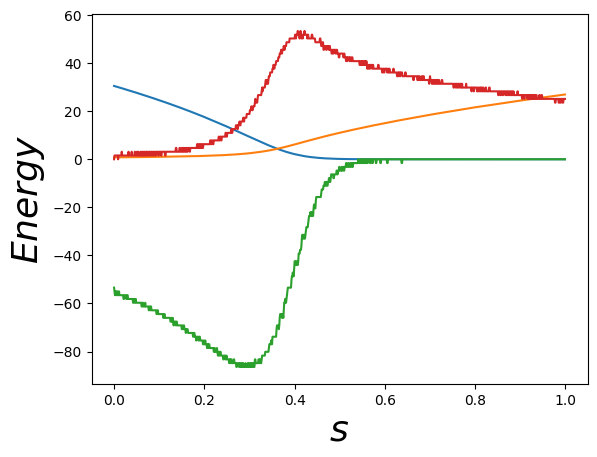

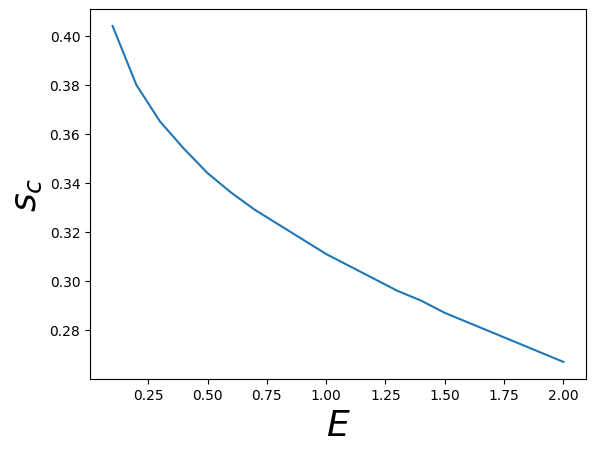

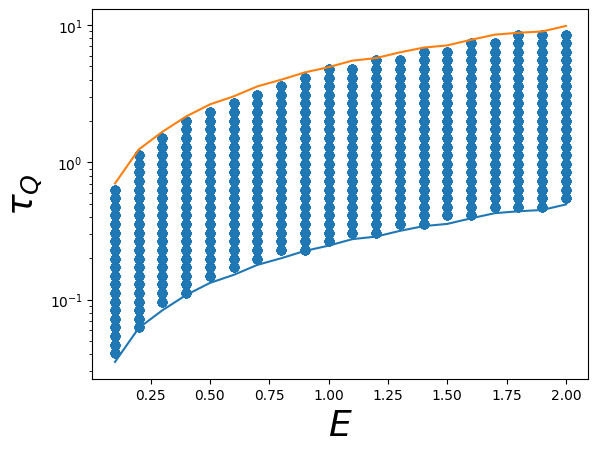

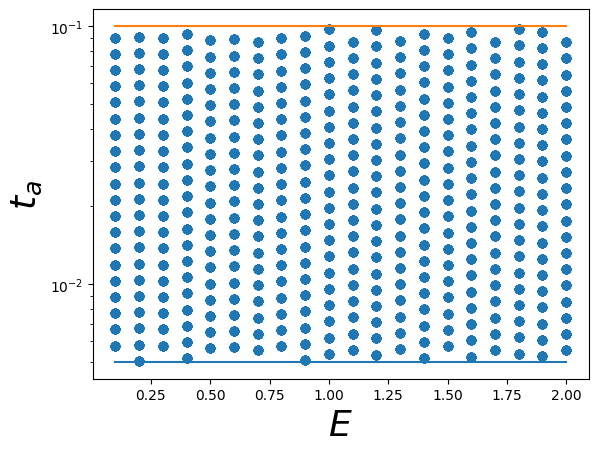

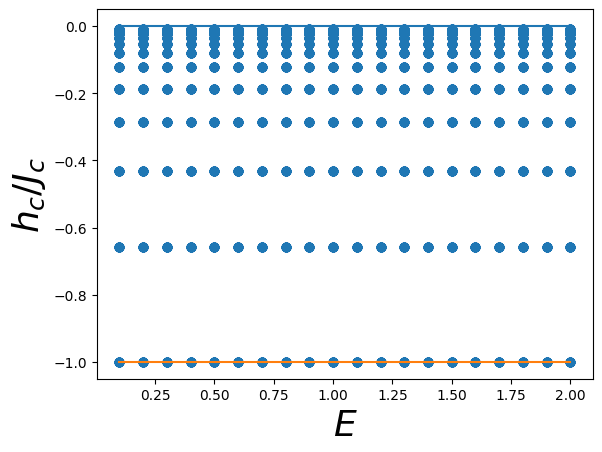

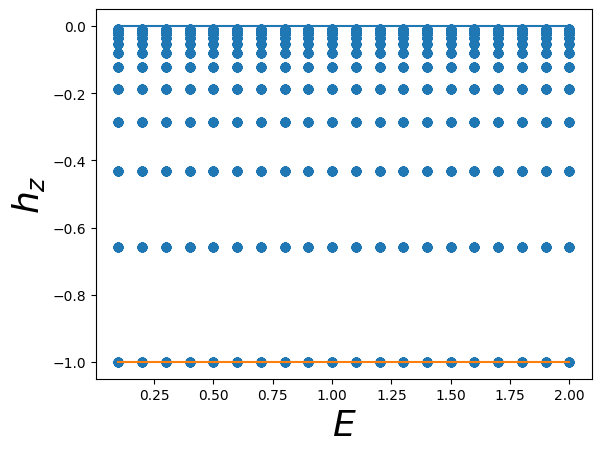

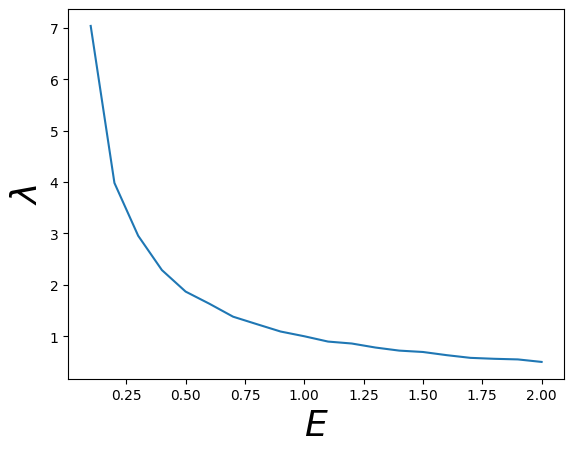

In [4]:
df = pd.read_csv('09-1265A-E_Advantage_system5_4_annealing_schedule.csv', sep=',', decimal='.')
sa = np.array([round(df['s'][i],3) for i in range(1000)])
Ga = np.array([round(df['A(s) (GHz)'][i],3)*np.pi for i in range(1000)])
Ja = np.array([round(df['B(s) (GHz)'][i],3)*np.pi for i in range(1000)])
gc = 3.04438

nos = 2436
Lx = 42
Ly = 29
J = -1.
num_reads = 1000
embedding_dir = 'D_Wave_data_dicts/'

def sc(E,gc=1.):
    return sa[np.argmin(abs(Ga-gc*E*Ja))]
def Jc(E,gc=1.):
    return E * Ja[np.argmin(abs(Ga-gc*E*Ja))]
def Gc(E,gc=1.):
    return Ga[np.argmin(abs(Ga-gc*E*Ja))]
def Jcp(E,gc=1.):
    return np.gradient(E*Ja,sa)[np.argmin(abs(Ga-gc*E*Ja))]
def Gcp(E,gc=1.):
    return np.gradient(Ga,sa)[np.argmin(abs(Ga-gc*E*Ja))]
def tQ(ta,E,gc=1.):
    # ta must be in ns
    return ta / gc * Jc(E,gc) / (Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc))
def tQ_to_ta(tq,E,gc=1.):
    # ta must be in ns
    return tq * gc / Jc(E,gc) * (Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc))
def hcoJc(h,E,gc=1.):
    return h
def hcoJc_to_hz(hcoJc,E,gc=1.):
    return hcoJc
def en_to_lambda(E,gc=1.):
    return ((Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc)) / Jc(E,gc)) / ((Jcp(1.,gc)/Jc(1.,gc) - Gcp(1.,gc)/Gc(1.,gc)) / Jc(1.,gc))

en_range = np.linspace(.1,2.,20).round(6)

fig, ax = plt.subplots()
plt.xlabel('$s$', fontsize = 26)
plt.ylabel('$Energy$', fontsize = 26)
ax.plot(sa, Ga)
ax.plot(sa, Ja)
ax.plot(sa, np.gradient(Ga,sa))
ax.plot(sa, np.gradient(Ja,sa))

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$s_c$', fontsize = 26)
ax.plot(en_range, [sc(e,gc=gc) for e in en_range])

ens, ens1, tqs, tas, hcojs, hzs = [], [], [], [], [], []
for en in en_range:
    for tq in np.geomspace(tQ(5,.1,gc=gc),tQ(100,2.,gc=gc),40):
        if tQ(5,en,gc=gc) < tq < tQ(100,en,gc=gc):
            for hz in np.geomspace(hcoJc(-1.,.1,gc=gc), hcoJc(-.01,.1,gc=gc), 12):
                if hcoJc(-1.,en,gc=gc) <= hz <= hcoJc(-.0,en,gc=gc):
                    hcojs.append(hz.round(6))
                    hzs.append(hcoJc_to_hz(hz,en,gc=gc).round(6))
                    ens.append(en.round(6))
                    tqs.append(tq.round(6))
                    tas.append((tQ_to_ta(tq,en,gc=gc)/1000.).round(6))

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel(r'$\tau_Q$', fontsize = 26)
ax.plot(en_range, [tQ(5,e,gc=gc) for e in en_range])
ax.plot(en_range, [tQ(100,e,gc=gc) for e in en_range])
ax.scatter(ens,tqs)
#ax.legend(['$t_Q(t_a=5 ns, E)$','$t_Q(t_a=100 ns, E)$'])
ax.set_yscale('log')

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$t_a$', fontsize = 26)
ax.plot(en_range, [tQ_to_ta(tQ(5,e,gc=gc)/1000.,e,gc=gc) for e in en_range])
ax.plot(en_range, [tQ_to_ta(tQ(100,e,gc=gc)/1000.,e,gc=gc) for e in en_range])
ax.scatter(ens,tas)
#ax.legend(['$t_Q(t_a=5 ns, E)$','$t_Q(t_a=100 ns, E)$'])
ax.set_yscale('log')

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$h_c/J_c$', fontsize = 26)
ax.plot(en_range, [hcoJc(-.0,e,gc=gc) for e in en_range])
ax.plot(en_range, [hcoJc(-1.,e,gc=gc) for e in en_range])
ax.scatter(ens,hcojs)

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel('$h_z$', fontsize = 26)
ax.plot(en_range, [-.0 for e in en_range])
ax.plot(en_range, [-1. for e in en_range])
ax.scatter(ens,hzs)

fig, ax = plt.subplots()
plt.xlabel('$E$', fontsize = 26)
plt.ylabel(r'$\lambda$', fontsize = 26)
ax.plot(en_range, [en_to_lambda(e,gc=gc) for e in en_range])

hzenta_range = [[ens[i],tas[i],hzs[i]] for i in range(len(ens))]

In [5]:
#Import results from D-Wave - Needed for the code below to work!

analysis_results_dir = 'D_Wave_data_dicts/'

with gzip.open(analysis_results_dir + '2D_tfim_6th_sweep_mag.txt.gz', "rt") as f:
    fvd_mags = eval(f.read().replace('nan','np.nan'))
with gzip.open(analysis_results_dir + '2D_tfim_6th_sweep_en.txt.gz', "rt") as f:
    fvd_ens = eval(f.read())

In [6]:
# PLOTTING CONVERSION

J_dict_keys = eval(open(embedding_dir + 'square-lattice-PBCish-'+str(Lx)+'x'+str(Ly)+'x2-native-5.4-'+str(nos)+ '-J_dict-keys.txt', 'r').read())
J_dict = {}
for key in J_dict_keys:
    J_dict[key] = J

mag = {}
corr = {}
nex = {}
mds = {}
evs = {}

for hzentaind, [en,ta,hz] in enumerate(hzenta_range):
    try:
        egs = np.sum([J_dict[q]*1*1 for q in J_dict.keys()]) + hz*np.sum([1 for i in range(nos)])
        mag[(hz,ta,en)] = fvd_mags[(nos,Lx,Ly,J,hz,ta,en,num_reads,'szmean')]
        nex[(hz,ta,en)] = fvd_mags[(nos,Lx,Ly,J,hz,ta,en,num_reads,'nexmean')]/nos
        mds[(hz,ta,en)] = np.sqrt(fvd_mags[(nos,Lx,Ly,J,hz,ta,en,num_reads,'domainsizemean')]/nos)
        evs[(hz,ta,en)] = (fvd_ens[(nos,Lx,Ly,J,hz,ta,en,num_reads,'enmean')]-egs+10**-6)/nos
    except:
        continue

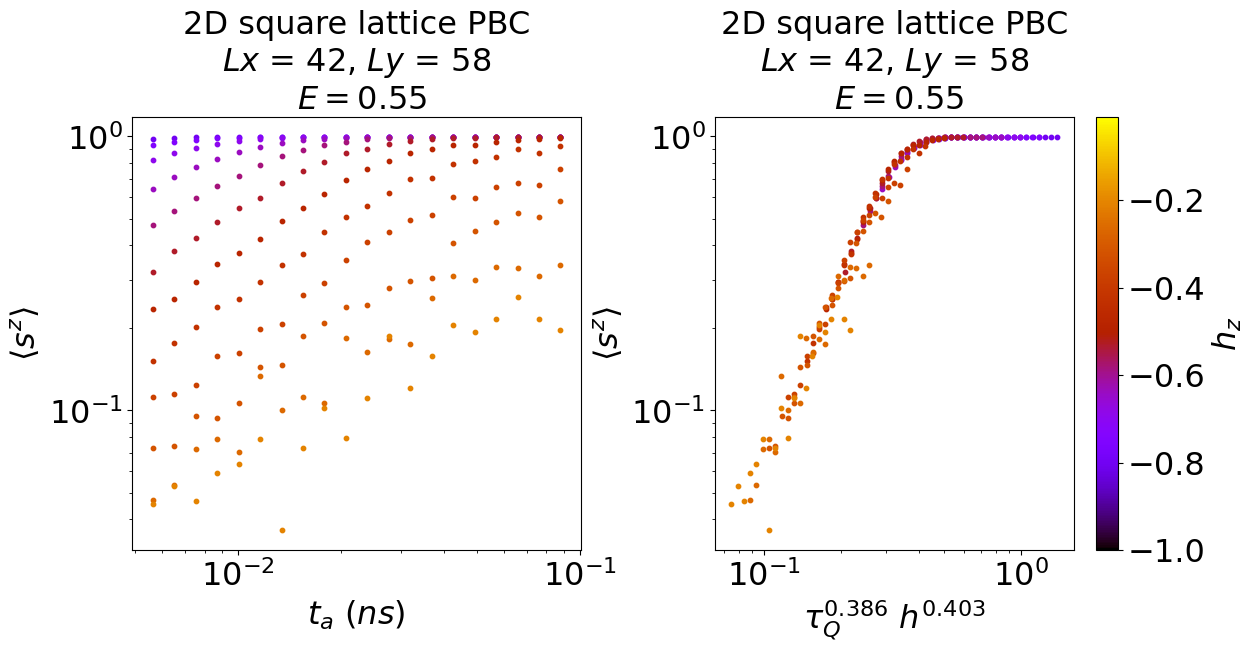

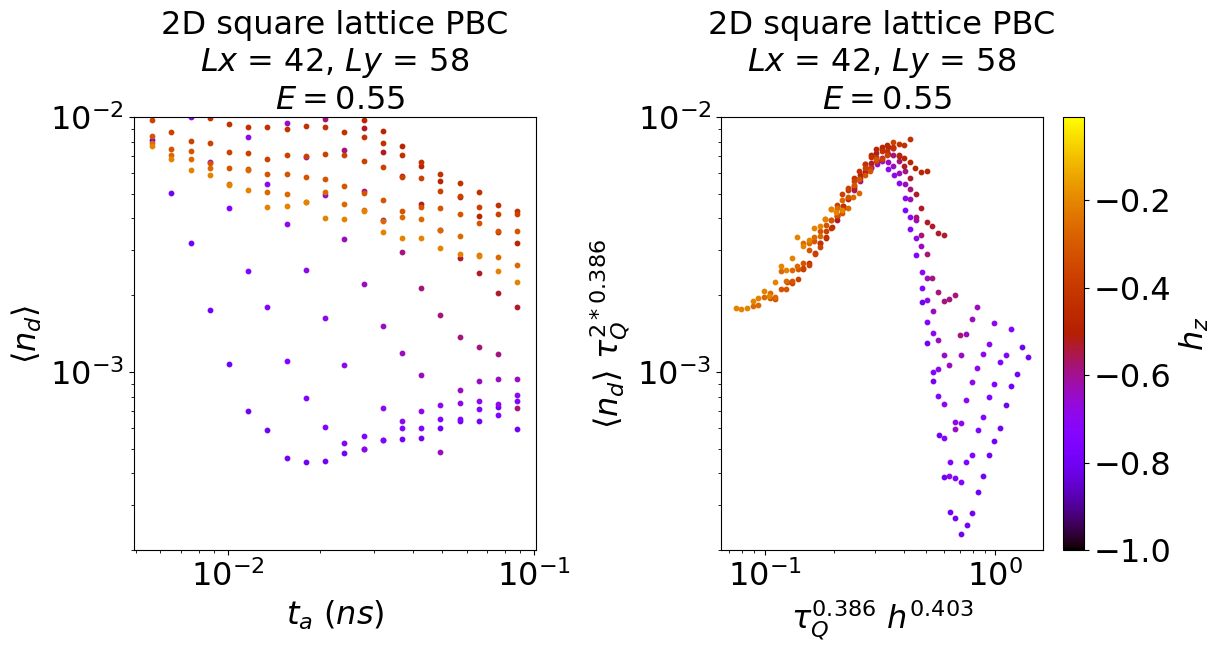

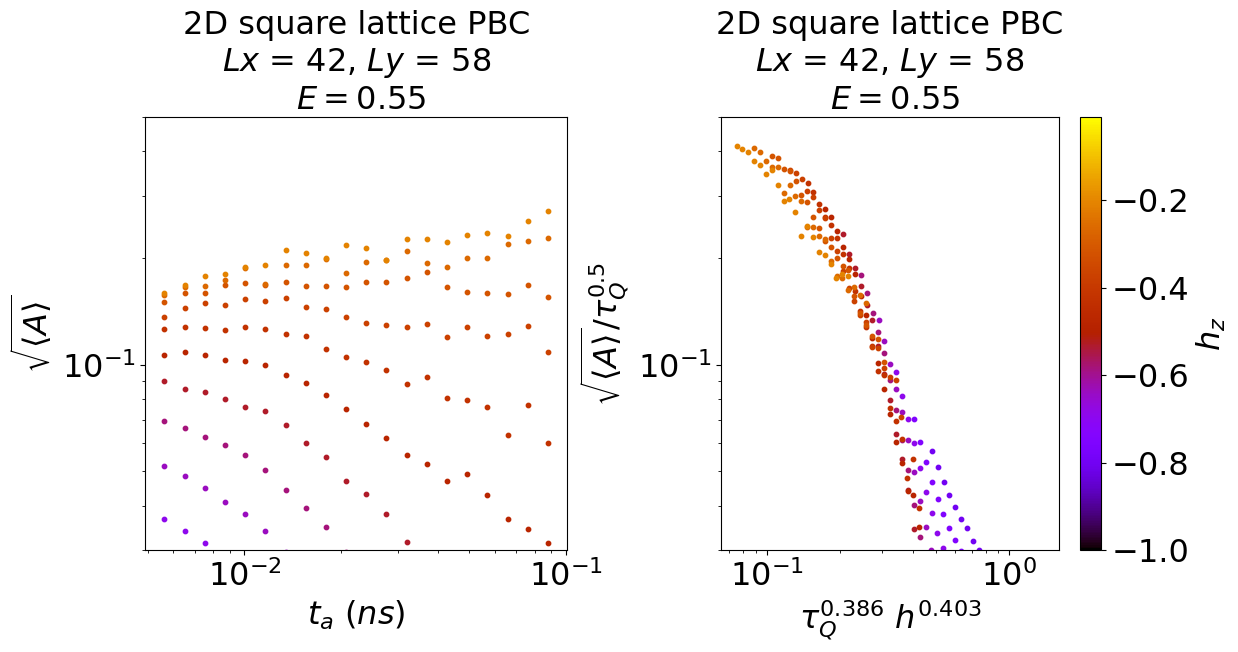

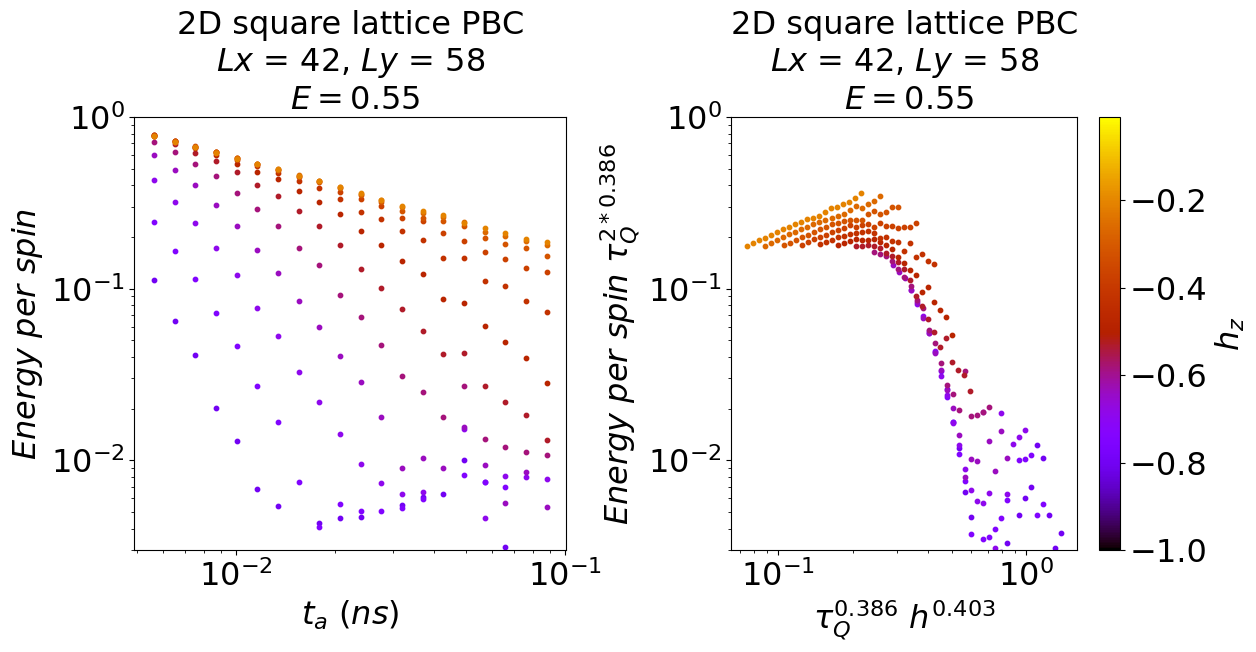

In [20]:
# PLOT RESULTS FOR A GIVEN E. CHOOSE A VALUE FROM [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]

choice_of_E = 0.5

if choice_of_E in en_range:

    third_axis = np.unique(np.array(hzs))
    third_axis_name = '$h_z$'
    
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(.2, .8, len(third_axis))]
    
    lw = .5
    s = 10
    
    xnex, ynex, xsz, ysz = np.array([]), np.array([]), np.array([]), np.array([])
    xmean = .15
        
    figsz, axsz = plt.subplots(1,2,figsize=(12,7))
    axsz[0].set_xlabel("$t_a$ ($ns$)", fontsize = 23)
    axsz[0].tick_params(axis='x',labelsize=23)
    axsz[0].tick_params(axis='y',labelsize=23)
    axsz[0].set_ylabel(r"$\langle s^z\rangle$", fontsize=23)
    axsz[0].set_title('2D square lattice PBC\n$Lx$ = '+str(Lx)+', $Ly$ = '+str(2*Ly)+'\n $E=$'+str(en), fontsize = 23)
    axsz[1].set_xlabel(r"$\tau_Q^{0.386}$ $h^{0.403}$", fontsize = 23)
    axsz[1].tick_params(axis='x',labelsize=23)
    axsz[1].tick_params(axis='y',labelsize=23)
    axsz[1].set_ylabel(r"$\langle s^z\rangle$", fontsize=23)
    axsz[1].set_title('2D square lattice PBC\n$Lx$ = '+str(Lx)+', $Ly$ = '+str(2*Ly)+'\n $E=$'+str(en), fontsize = 23)
    
    fignex, axnex = plt.subplots(1,2,figsize=(12,7))
    axnex[0].set_xlabel("$t_a$ ($ns$)", fontsize = 23)
    axnex[0].tick_params(axis='x',labelsize=23)
    axnex[0].tick_params(axis='y',labelsize=23)
    axnex[0].set_ylabel(r"$\langle n_d\rangle$", fontsize=23)
    axnex[0].set_title('2D square lattice PBC\n$Lx$ = '+str(Lx)+', $Ly$ = '+str(2*Ly)+'\n $E=$'+str(en), fontsize = 23)
    axnex[1].set_xlabel(r"$\tau_Q^{0.386}$ $h^{0.403}$", fontsize = 23)
    axnex[1].tick_params(axis='x',labelsize=23)
    axnex[1].tick_params(axis='y',labelsize=23)
    axnex[1].set_ylabel(r"$\langle n_d\rangle$ $\tau_Q^{2*0.386}$", fontsize=23)
    axnex[1].set_title('2D square lattice PBC\n$Lx$ = '+str(Lx)+', $Ly$ = '+str(2*Ly)+'\n $E=$'+str(en), fontsize = 23)
    
    figmds, axmds = plt.subplots(1,2,figsize=(12,7))
    axmds[0].set_xlabel("$t_a$ ($ns$)", fontsize = 23)
    axmds[0].tick_params(axis='x',labelsize=23)
    axmds[0].tick_params(axis='y',labelsize=23)
    axmds[0].set_ylabel(r"$\sqrt{\langle A\rangle}$", fontsize=23)
    axmds[0].set_title('2D square lattice PBC\n$Lx$ = '+str(Lx)+', $Ly$ = '+str(2*Ly)+'\n $E=$'+str(en), fontsize = 23)
    axmds[1].set_xlabel(r"$\tau_Q^{0.386}$ $h^{0.403}$", fontsize = 23)
    axmds[1].tick_params(axis='x',labelsize=23)
    axmds[1].tick_params(axis='y',labelsize=23)
    axmds[1].set_ylabel(r"$\sqrt{\langle A\rangle}/\tau_Q^{0.5}$", fontsize=23)
    axmds[1].set_title('2D square lattice PBC\n$Lx$ = '+str(Lx)+', $Ly$ = '+str(2*Ly)+'\n $E=$'+str(en), fontsize = 23)
    
    figevs, axevs = plt.subplots(1,2,figsize=(12,7))
    axevs[0].set_xlabel("$t_a$ ($ns$)", fontsize = 23)
    axevs[0].tick_params(axis='x',labelsize=23)
    axevs[0].tick_params(axis='y',labelsize=23)
    axevs[0].set_ylabel(r"$Energy$ $per$ $spin$", fontsize=23)
    axevs[0].set_title('2D square lattice PBC\n$Lx$ = '+str(Lx)+', $Ly$ = '+str(2*Ly)+'\n $E=$'+str(en), fontsize = 23)
    axevs[1].set_xlabel(r"$\tau_Q^{0.386}$ $h^{0.403}$", fontsize = 23)
    axevs[1].tick_params(axis='x',labelsize=23)
    axevs[1].tick_params(axis='y',labelsize=23)
    axevs[1].set_ylabel(r"$Energy$ $per$ $spin$ $\tau_Q^{2*0.386}$", fontsize=23)
    axevs[1].set_title('2D square lattice PBC\n$Lx$ = '+str(Lx)+', $Ly$ = '+str(2*Ly)+'\n $E=$'+str(en), fontsize = 23)
    
    for taxind, tax in enumerate(third_axis):
        for enind, en in enumerate([choice_of_E]):
            
            tas1 = np.unique(np.array(tas))
            tqs = np.array([tQ(ta*1000,en,gc=gc) for ta in tas1])
            mag1 = np.full(len(tas1),-2.)
            nex1 = np.full(len(tas1),-2.)
            mds1 = np.full(len(tas1),-2.)
            evs1 = np.full(len(tas1),-2.)
            for taind, ta in enumerate(tas1):
                try:
                    mag1[taind] = mag[(tax,ta,en)]
                    nex1[taind] = nex[(tax,ta,en)]
                    mds1[taind] = mds[(tax,ta,en)]
                    evs1[taind] = evs[(tax,ta,en)]
                except:
                    mag1[taind] = np.nan
                    nex1[taind] = np.nan
                    mds1[taind] = np.nan
                    evs1[taind] = np.nan
    
            axsz[0].scatter(tas1,mag1, color=colors[taxind], s=s)
            axsz[0].plot(tas1,mag1, color=colors[taxind], lw=lw)
            axsz[1].scatter(tqs**(.386)*abs(tax)**(.403),mag1, color=colors[taxind], s=s)
            #axsz[1].plot(np.sqrt(tqs)*abs(en*tax/Jc(en))**(8/15),mag[taxind,:,enind], color=colors[taxind], lw=lw)
            axnex[0].scatter(tas1,nex1, color=colors[taxind], s=s)
            axnex[0].plot(tas1,nex1, color=colors[taxind], lw=lw)
            axnex[1].scatter(tqs**(.386)*abs(tax)**(.403),nex1*tqs**(2*.386), color=colors[taxind], s=s)
            #axnex[1].plot(np.sqrt(tqs)*abs(en*tax/Jc(en))**(8/15),np.sqrt(tqs)*nex[taxind,:,enind], color=colors[taxind], lw=lw)
            axmds[0].scatter(tas1,mds1, color=colors[taxind], s=s)
            axmds[0].plot(tas1,mds1, color=colors[taxind], lw=lw)
            axmds[1].scatter(tqs**(.386)*abs(tax)**(.403),mds1/tqs**(.5), color=colors[taxind], s=s)
            #axmds[1].plot(np.sqrt(tqs)*abs(en*tax/Jc(en))**(8/15),np.sqrt(tqs)*nex[taxind,:,enind], color=colors[taxind], lw=lw)
            axevs[0].scatter(tas1,evs1, color=colors[taxind], s=s)
            axevs[0].plot(tas1,evs1, color=colors[taxind], lw=lw)
            axevs[1].scatter(tqs**(.386)*abs(tax)**(.403),evs1*tqs**(2*.386), color=colors[taxind], s=s)
            #axmds[1].plot(np.sqrt(tqs)*abs(en*tax/Jc(en))**(8/15),np.sqrt(tqs)*nex[taxind,:,enind], color=colors[taxind], lw=lw)
            
    figsz.tight_layout(pad=2.5)
    fignex.tight_layout(pad=2.5)
    figmds.tight_layout(pad=2.5)
    figevs.tight_layout(pad=2.5)
    normalize = mcolors.Normalize(vmin=min(third_axis), vmax=max(third_axis))
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=cmap)
    scalarmappaple.set_array(third_axis)
    cbar = plt.colorbar(scalarmappaple, ax=axsz[1])
    cbar.set_label(label=third_axis_name, size='23')
    cbar.ax.tick_params(labelsize='23')
    cbar = plt.colorbar(scalarmappaple, ax=axnex[1])
    cbar.set_label(label=third_axis_name, size='23')
    cbar.ax.tick_params(labelsize='23')
    cbar = plt.colorbar(scalarmappaple, ax=axmds[1])
    cbar.set_label(label=third_axis_name, size='23')
    cbar.ax.tick_params(labelsize='23')
    cbar = plt.colorbar(scalarmappaple, ax=axevs[1])
    cbar.set_label(label=third_axis_name, size='23')
    cbar.ax.tick_params(labelsize='23')
    axsz[0].set_xscale('log')
    axsz[0].set_yscale('log')
    axsz[1].set_xscale('log')
    axsz[1].set_yscale('log')
    axnex[0].set_xscale('log')
    axnex[0].set_yscale('log')
    axnex[1].set_xscale('log')
    axnex[1].set_yscale('log')
    axmds[0].set_xscale('log')
    axmds[0].set_yscale('log')
    axmds[1].set_xscale('log')
    axmds[1].set_yscale('log')
    axevs[0].set_xscale('log')
    axevs[0].set_yscale('log')
    axevs[1].set_xscale('log')
    axevs[1].set_yscale('log')
    axnex[0].set_ylim(.0002,.01)
    axnex[1].set_ylim(.0002,.01)
    axmds[0].set_ylim(.03,.5)
    axmds[1].set_ylim(.03,.5)
    axevs[0].set_ylim(.003,1.)
    axevs[1].set_ylim(.003,1.)

else:

    print('Your choice of E is not available!')

# D-Wave Spin Configuration Domain Analysis
This notebook demonstrates how to analyze spin configurations sampled from D-Wave to extract domain sizes and compute the distribution $P_A$ vs $A$.

In [5]:
# Flood fill with periodic boundary conditions
def floodFill(image, x, y, newChar, oldChar=None):
    if oldChar is None:
        oldChar = image[y][x]
    if oldChar == newChar or image[y][x] != oldChar:
        return
    stack = [(x, y)]
    while stack:
        x, y = stack.pop()
        if image[y][x] == oldChar:
            image[y][x] = newChar
            stack.append(((x + 1) % WIDTH, y))
            stack.append(((x - 1) % WIDTH, y))
            stack.append((x, (y + 1) % HEIGHT))
            stack.append((x, (y - 1) % HEIGHT))

In [6]:
def loops(image):
    domain_sizes = []
    domain_nr = 0
    oldChar = 0
    for y, row in enumerate(image):
        for x, val in enumerate(row):
            if val == oldChar:
                domain_nr += 1
                floodFill(image, x, y, domain_nr, oldChar=oldChar)
                domain_sizes.append(np.sum(image == domain_nr))
    return np.array(domain_sizes).astype(int)

In [7]:
# Load configuration
config = np.load("example_configuration.npy")
HEIGHT, WIDTH = config.shape

In [8]:
# Analyze configuration
def analyze_spin_configuration(spin_config):
    global WIDTH, HEIGHT
    HEIGHT, WIDTH = spin_config.shape
    domain_sizes = []
    spin_config = (-(spin_config-1)/2).astype(int) - 1
    domain_sizes.extend(loops(spin_config))
    print(domain_sizes)
    area_counts = Counter(domain_sizes)
    A_vals = np.array(sorted(area_counts))
    P_A_vals = np.array([area_counts[a] / (HEIGHT * WIDTH) for a in A_vals])
    return A_vals, P_A_vals

A_vals, P_A_vals = analyze_spin_configuration(config)

[np.int64(19), np.int64(233), np.int64(11), np.int64(137), np.int64(7), np.int64(317), np.int64(1), np.int64(1), np.int64(13), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(9)]


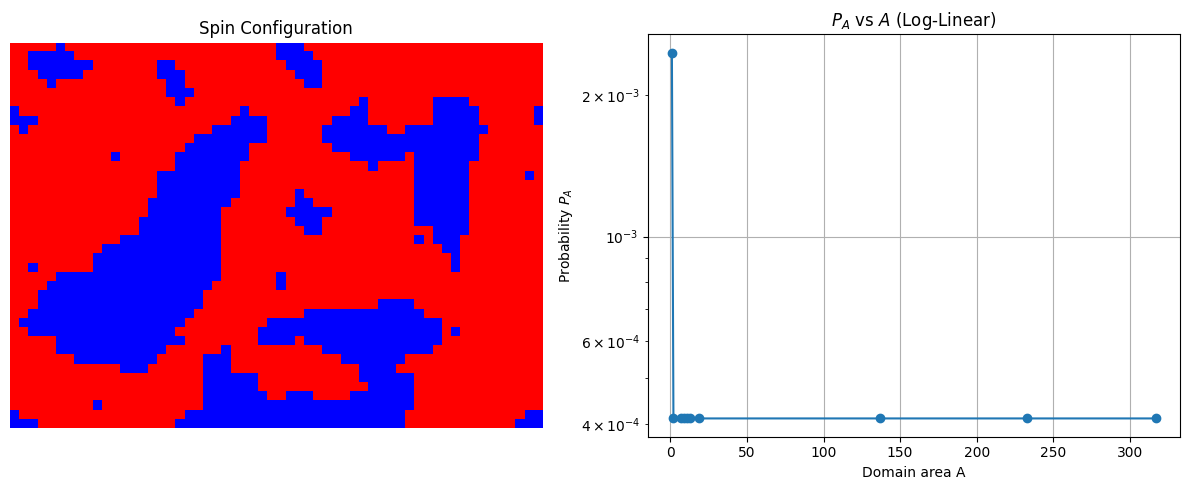

In [9]:
# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(config, cmap='bwr', interpolation='nearest')
axs[0].set_title("Spin Configuration")
axs[0].axis('off')
axs[1].semilogy(A_vals, P_A_vals, 'o-')
axs[1].set_xlabel("Domain area A")
axs[1].set_ylabel("Probability $P_A$")
axs[1].set_title("$P_A$ vs $A$ (Log-Linear)")
axs[1].grid(True)
plt.tight_layout()
plt.show()

# D-Wave Spin Configurations
# The parameters you choose to plot must come from hzs, tas, and ens that are printed out below.

In [31]:
def xy_to_index(r, Lx, Ly):
    """Translates a squre grid coordinate (x, y) of a point to an index of the point."""
    x,y = r
    z = 0
    return Lx*y + x

def lattice_move(r, dr):
    """Takes an initial vector r of coordinates of K_{4,4} subgraphs on the Pegasus graph and a shift vector dr and outputs the coordinates of the shifted vector."""
    z0, y0 ,x0 = r
    dz, dy, dx = dr

    new_x = x0 + dx
    new_y = y0 + dy
    new_z = z0 + dz

    if new_z >= 2: # if the z depth over 2 the point shifts diagonally (x+1,y-1) to a different plane (z-depth) 
        shift = new_z // 3
        new_x = new_x + shift
        new_y = new_y - shift
        new_z =  new_z % 3

    if new_z < 0: # if the z depth less than 0 the point shifts diagonally to a different plane
        shift = new_z // 3
        new_x = new_x - shift
        new_y = new_y + shift
        new_z =  new_z % 3

    return (new_z, new_y, new_x)

def square_lattice(Lx,Ly):
    """Creates a square lattice grid with open boundary conditions of size L on the Pegasus graph.
      Outputs a dictionary of lattice indicies and the corresponding qubit indicies on the Pegaus graph.
      The origin of the lattice on the graph can be adjusted using the X0, Y0, Z0, coordiantes.
      
      The lattice is constructed by tiling smaller 4x4 squares. 
      """
    coords_dict = {}

    X0 = 0
    #Y0 = 14
    Y0 = 9
    Z0 = 1
    R0 = (Z0, Y0, X0)

    for y in range(Ly):
        for x in range(Lx):

            if y % 4 == 0: # 
                
                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 1)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 1)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 3)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 2)
                    
            if y % 4 == 1: # 

                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)-1))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 2)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 1)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 1)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 3)

            if y % 4 == 2: # 

                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)-1))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 3)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 2)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 1)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4) + 2, -(y//4), (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 1)

            if y % 4 == 3: # 

                if x % 4 == 0:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 1)
                if x%4 == 1:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 3)
                if x%4 == 2:
                    Z, Y, X = lattice_move(R0, ((y//4) + 1, -(y//4)-1, (x//4)))
                    coords_dict[(x, y)] = (Z, Y, X, 1, 2)
                if x%4 == 3:
                    Z, Y, X = lattice_move(R0, ((y//4), -(y//4)-1, (x//4)+1))
                    coords_dict[(x, y)] = (Z, Y, X, 0, 1)
                    

    return coords_dict

In [41]:
# RUN THIS CELL TO GET THE PARAMETERS RAN ON D-WAVE

df = pd.read_csv('09-1265A-E_Advantage_system5_4_annealing_schedule.csv', sep=',', decimal='.')
sa = np.array([round(df['s'][i],3) for i in range(1000)])
Ga = np.array([round(df['A(s) (GHz)'][i],3)*np.pi for i in range(1000)])
Ja = np.array([round(df['B(s) (GHz)'][i],3)*np.pi for i in range(1000)])
gc = 3.04438

def sc(E,gc=1.):
    return sa[np.argmin(abs(Ga-gc*E*Ja))]
def Jc(E,gc=1.):
    return E * Ja[np.argmin(abs(Ga-gc*E*Ja))]
def Gc(E,gc=1.):
    return Ga[np.argmin(abs(Ga-gc*E*Ja))]
def Jcp(E,gc=1.):
    return np.gradient(E*Ja,sa)[np.argmin(abs(Ga-gc*E*Ja))]
def Gcp(E,gc=1.):
    return np.gradient(Ga,sa)[np.argmin(abs(Ga-gc*E*Ja))]
def tQ(ta,E,gc=1.):
    # ta must be in ns
    return ta / gc * Jc(E,gc) / (Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc))
def tQ_to_ta(tq,E,gc=1.):
    # ta must be in ns
    return tq * gc / Jc(E,gc) * (Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc))
def hcoJc(h,E,gc=1.):
    return h
def hcoJc_to_hz(hcoJc,E,gc=1.):
    return hcoJc
def en_to_lambda(E,gc=1.):
    return ((Jcp(E,gc)/Jc(E,gc) - Gcp(E,gc)/Gc(E,gc)) / Jc(E,gc)) / ((Jcp(1.,gc)/Jc(1.,gc) - Gcp(1.,gc)/Gc(1.,gc)) / Jc(1.,gc))

en_range = np.linspace(.1,2.,20).round(6)

ens, ens1, tqs, tas, hcojs, hzs = [], [], [], [], [], []
for en in en_range:
    for tq in np.geomspace(tQ(5,.1,gc=gc),tQ(100,2.,gc=gc),40):
        if tQ(5,en,gc=gc) < tq < tQ(100,en,gc=gc):
            for hz in np.geomspace(hcoJc(-1.,.1,gc=gc), hcoJc(-.01,.1,gc=gc), 12):
                if hcoJc(-1.,en,gc=gc) <= hz <= hcoJc(-.0,en,gc=gc):
                    hcojs.append(hz.round(6))
                    hzs.append(hcoJc_to_hz(hz,en,gc=gc).round(6))
                    ens.append(en.round(6))
                    tqs.append(tq.round(6))
                    tas.append((tQ_to_ta(tq,en,gc=gc)/1000.).round(6))

In [42]:
np.unique(hzs)

array([-1.      , -0.657933, -0.432876, -0.284804, -0.187382, -0.123285,
       -0.081113, -0.053367, -0.035112, -0.023101, -0.015199, -0.01    ])

In [43]:
np.unique(tas)

array([0.005045, 0.005084, 0.005167, 0.005177, 0.005247, 0.00527 ,
       0.005338, 0.005378, 0.005385, 0.005549, 0.005561, 0.005573,
       0.005605, 0.005637, 0.005691, 0.00575 , 0.00576 , 0.005777,
       0.005778, 0.00583 , 0.005874, 0.005971, 0.005982, 0.006063,
       0.00609 , 0.006168, 0.006215, 0.006223, 0.006412, 0.006426,
       0.006439, 0.006477, 0.006514, 0.006577, 0.006645, 0.006656,
       0.006676, 0.006737, 0.006788, 0.0069  , 0.006912, 0.007007,
       0.007037, 0.007128, 0.007182, 0.007191, 0.00741 , 0.007425,
       0.007441, 0.007484, 0.007527, 0.0076  , 0.007678, 0.007691,
       0.007715, 0.007785, 0.007844, 0.007973, 0.007988, 0.008096,
       0.008132, 0.008236, 0.008299, 0.00831 , 0.008562, 0.00858 ,
       0.008598, 0.008648, 0.008698, 0.008782, 0.008873, 0.008887,
       0.008915, 0.008996, 0.009064, 0.009214, 0.00923 , 0.009356,
       0.009396, 0.009518, 0.00959 , 0.009602, 0.009894, 0.009915,
       0.009936, 0.009994, 0.010051, 0.010148, 0.010253, 0.010

In [44]:
np.unique(ens)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [45]:
# DEFINITION THE PARAMETERS USED ON D-WAVE. JUST RUN THE CELL.

nos = 2436
Lx = 42
Ly = 29
J = -1.

profil = 'jvodebjuelich'
num_reads = 1000
embedding_string_short = 'sl54PBCish'
auto_scale = False
answer_mode="raw"
fast_anneal=True

embedding_dir = 'D_Wave_data_dicts/'
embstr = embedding_dir + 'square-lattice-PBCish-'+str(Lx)+'x'+str(Ly)+'x2-native-5.4-'+str(nos)+'.txt'
embedding = eval(open(embstr, 'r').read())

coords = square_lattice(Lx,Ly)
conf = np.full((Lx,2*Ly),-2).astype(int)
indices = np.full(Lx*2*Ly,-2).astype(int)
coordmat = np.full((Lx,2*Ly),-2).astype(int)
for xy, v in coords.items():
    x, y = xy
    index = xy_to_index(xy, Lx, Ly)
    coordmat[x,y] = index
    coordmat[x,2*Ly-y-1] = index + Lx*Ly
for x in range(Lx):
    for y in range(2*Ly):
        indices[x*2*Ly+y] = coordmat[x,y]

Closest file found:
  2D_TFIM_nos_2436_Lx_42_Ly_29_J_-1_0_hz_-0_01_ta_0_005637_en_0_5_nr_1000_emb_sl54PBCish_LQ_2436_PQ_2436_fa_True_am_raw_as_False.txt


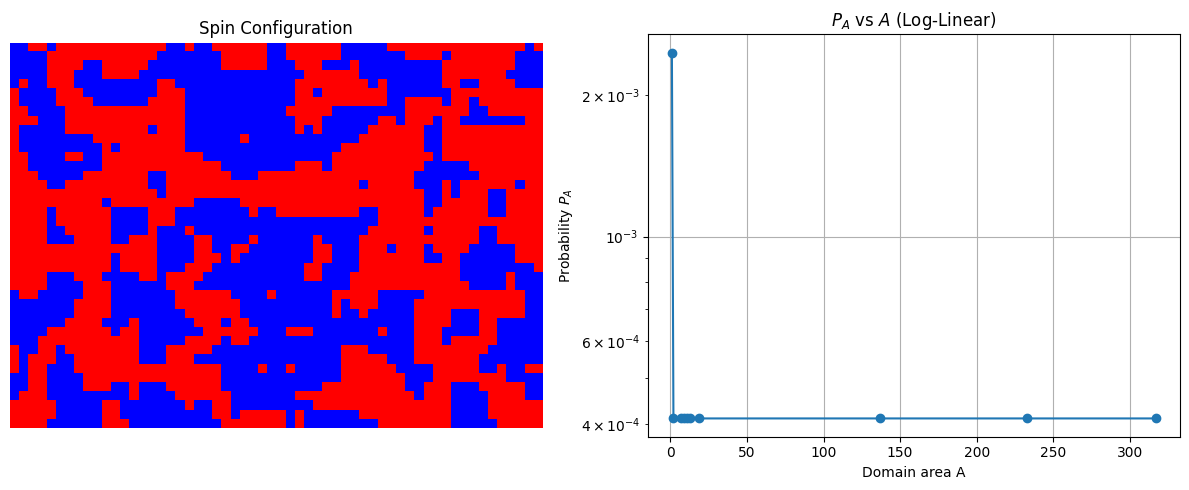

In [61]:
# Target values
hz_target = -0.01
ta_target = 0.0054 # IN MICROSECONDS. BE CAREFUL WHICH FILE IS ACTUALLY FOUND! IT MIGHT HAVE A DIFFERENT ANNEALING TIME VALUE.
en_target = 0.5

# Directory to search
#results_dir = 'C:/Users/jakav/Desktop/IJS/D-Wave/FastAnnealing/QuantumAnnealer/Results/Results-6th-sweep/'
results_dir = 'D_Wave_data_dicts/'

# Pattern to extract hz, ta, en from filenames
pattern = re.compile(r"_hz_(-?\d+_\d+)_ta_(\d+_\d+)_en_(\d+_\d+)_")

closest_file = None
min_distance = float('inf')

# Loop through files and extract hz, ta, en
for fname in os.listdir(results_dir):
    match = pattern.search(fname)
    if match:
        try:
            hz_val = float(match.group(1).replace('_', '.'))
            ta_val = float(match.group(2).replace('_', '.'))
            en_val = float(match.group(3).replace('_', '.'))

            # Compute distance to target values
            dist = np.sqrt((hz_val - hz_target)**2 + (ta_val - ta_target)**2 + (en_val - en_target)**2)

            if dist < min_distance:
                min_distance = dist
                closest_file = fname
        except ValueError:
            continue  # skip if conversion fails

# Report result
if closest_file:
    print(f"Closest file found:\n  {closest_file}")

    # Load results
    results = dimod.SampleSet.from_serializable(pickle.load(lzma.open(results_dir + closest_file,'rb'))).to_pandas_dataframe()
else:
    print("No matching file found.")

config = results.iloc[randrange(num_reads)][indices].to_numpy().astype(int).reshape((Lx,2*Ly))

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(config, cmap='bwr', interpolation='nearest')
axs[0].set_title("Spin Configuration")
axs[0].axis('off')
axs[1].semilogy(A_vals, P_A_vals, 'o-')
axs[1].set_xlabel("Domain area A")
axs[1].set_ylabel("Probability $P_A$")
axs[1].set_title("$P_A$ vs $A$ (Log-Linear)")
axs[1].grid(True)
plt.tight_layout()
plt.show()